In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

In [2]:
# pip install xgboost

In [2]:
file_train = pd.read_csv('counterfeit_train.csv')
file_test = pd.read_csv('counterfeit_test.csv')

file_test['Counterfeit_Sales'] = np.nan
file_test = file_test[file_train.columns]
file_train['Data'] = 'Train'
file_test['Data'] = 'Test'

In [3]:
zscore_comp = np.abs(stats.zscore(file_train['Counterfeit_Sales']))

threshold=3
drp_idx = np.where(zscore_comp>threshold)[0]

file_train.drop(drp_idx, inplace=True)
#print(np.where(zscore_comp>threshold), len(drp_idx))

file_conc = pd.concat([file_train, file_test], axis=0)

In [4]:
file_conc

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales,Data
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026,Train
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520,Train
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920,Train
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130,Train
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,KXW10,NaN,Area027,1983,136.5704,Hreplacements,mild,0.050505,CityLimits,Tier 3,Medium,NaN,Test
1701,CKE54,21.300,Area035,2002,57.0744,Antibiotics,critical,0.041118,DownTown,Tier 2,Small,NaN,Test
1702,HAY13,20.400,Area017,2005,182.7422,Antiseptics,mild,0.191273,DownTown,Tier 2,Unknown,NaN,Test
1703,ZEE32,20.000,Area018,2007,266.9672,Hreplacements,mild,0.013000,Industrial,Tier 3,Medium,NaN,Test


In [5]:
file_conc.shape

(8457, 13)

In [6]:
file_conc.isnull().sum()

Medicine_ID               0
Counterfeit_Weight     1418
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales      1705
Data                      0
dtype: int64

In [7]:
file_conc.describe()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Counterfeit_Sales
count,7039.000000,8457.000000,8457.000000,8457.000000,6752.000000
mean,14.160105,1995.892397,150.626798,0.079176,2218.309594
std,4.644078,8.342452,61.996780,0.051682,1574.918554
min,5.855000,1983.000000,41.590000,0.013000,146.290000
25%,10.075000,1985.000000,103.812000,0.039993,923.611500
50%,13.900000,1997.000000,152.447000,0.066840,1878.701600
75%,18.150000,2002.000000,195.260800,0.107807,3161.698200
max,22.650000,2007.000000,277.188400,0.341391,7360.233000


In [8]:
#Missing values replacement - Counterfeit_Weight has been substituted with the weights of similar Medicine_ID
miss_val_repla = file_conc.groupby(['Medicine_ID'])['Counterfeit_Weight'].mean().to_dict()
for key, values in miss_val_repla.items():
    file_conc.loc[file_conc['Medicine_ID'] == key, 'Counterfeit_Weight'] = np.round(values)

# file_conc.drop(file_conc[file_conc['Counterfeit_Weight'].isna()].index ,  inplace=True)

In [9]:
file_conc.isnull().sum()

Medicine_ID               0
Counterfeit_Weight        4
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales      1705
Data                      0
dtype: int64

In [10]:
for col in file_conc.columns:
    if (col not in ['Counterfeit_Sales', 'Data']) & (file_conc[col].isnull().sum()>0):
        file_conc.loc[file_conc[col].isnull(),col] = file_conc.loc[file_conc['Data'] == 'Train',col].mean()

In [11]:
file_conc.isnull().sum()

Medicine_ID               0
Counterfeit_Weight        0
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales      1705
Data                      0
dtype: int64

C:\Users\sunpatil\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Counterfeit_Sales', ylabel='Density'>

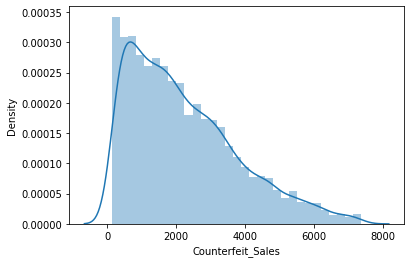

In [12]:
sns.distplot(file_train['Counterfeit_Sales'])

In [13]:
# miss_val_repla1 = file_conc.groupby(['Medicine_Type'])['Counterfeit_Weight'].mean().to_dict()
# for key, values in miss_val_repla1.items():
#     file_conc.loc[file_conc['Medicine_Type'] == key, 'Counterfeit_Weight'] = np.round(values)

# file_conc.drop(file_conc[file_conc['Counterfeit_Weight'].isna()].index ,  inplace=True)

In [14]:
# sns.distplot(file_train['Counterfeit_Sales'])

<AxesSubplot:xlabel='Counterfeit_Sales'>

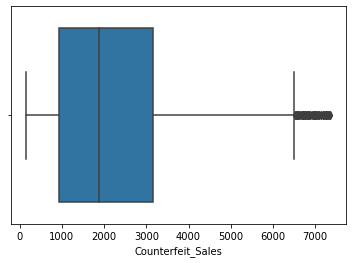

In [15]:
sns.boxplot(x = file_train['Counterfeit_Sales'])

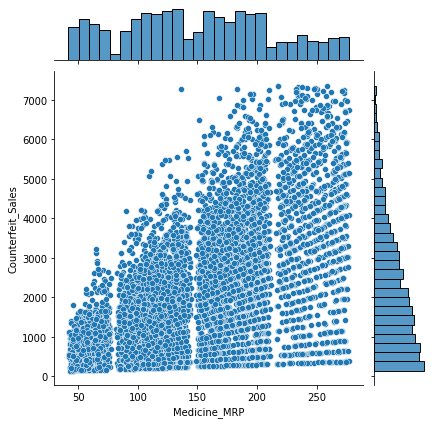

In [16]:
sns.jointplot(x ='Medicine_MRP', y='Counterfeit_Sales', data=file_conc)

In [12]:
##Discretizing numerical data
from sklearn.preprocessing import KBinsDiscretizer

disctrize = KBinsDiscretizer(n_bins=8, encode ='ordinal', strategy='quantile')
file_conc['Availability_rating_bins'] = disctrize.fit_transform(file_conc['Availability_rating'].values.reshape(-1,1)).astype(int)

cols_to_disc = ['Counterfeit_Weight','Medicine_MRP']
cols_to_disc_bins = ['Counterfeit_Weight_bins','Medicine_MRP_bins']
disctrize = KBinsDiscretizer(n_bins=8, encode ='ordinal', strategy='quantile')

file_conc[cols_to_disc_bins] = file_conc[cols_to_disc]
file_conc[cols_to_disc_bins] = disctrize.fit_transform(file_conc[cols_to_disc]).astype(int)

#file_conc.drop(cols_to_disc ,axis=1 ,inplace=True)
#del file_conc['Availability_rating']

<AxesSubplot:>

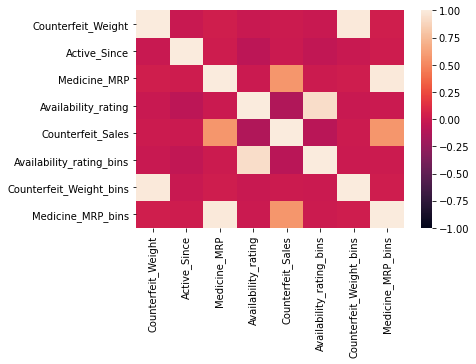

In [18]:
sns.heatmap(file_conc.corr(), vmin=-1, vmax=1)

In [13]:
file_conc.shape

(8457, 16)

In [14]:
# for col in ['SidEffect_Level', 'Area_Type','Area_City_Type', 'Area_dist_level']:
#             temp = pd.get_dummies(file_conc[col], prefix=col, drop_first=True)
#             file_conc = pd.concat([temp, file_conc], 1)
#             file_conc.drop([col],1,inplace=True)

In [15]:
col_to_crt_dummy=['SidEffect_Level', 'Area_Type', 'Area_City_Type', 'Area_dist_level']
for cat_col in col_to_crt_dummy:
    dummy_col = pd.get_dummies(file_conc[cat_col], drop_first=True, prefix=cat_col)
    file_conc  = pd.concat([file_conc , dummy_col], axis=1, ignore_index=False)
    del file_conc[cat_col]

In [16]:
for col in ['Active_Since']:
    temp = pd.get_dummies(file_conc[col], prefix=col, drop_first=True)
    file_conc = pd.concat([temp, file_conc], 1)
    file_conc.drop([col],1,inplace=True)

In [17]:
file_conc.select_dtypes(['object']).columns

Index(['Medicine_ID', 'DistArea_ID', 'Medicine_Type', 'Data'], dtype='object')

In [18]:
#Encoding
#DistArea_ID , Medicine_Type
import category_encoders as ce

file_conc['DistArea_ID'] = file_conc['DistArea_ID'].replace('Area', '')
be = ce.BinaryEncoder(cols=['DistArea_ID'])
cityCodes = be.fit_transform(file_conc['DistArea_ID'] , file_conc['Counterfeit_Sales'])
file_conc  = pd.concat([file_conc, cityCodes] , axis=1)

# del file_conc['DistArea_ID_0']
medicine_type_enc = file_conc['Medicine_Type'].value_counts().to_dict()
file_conc['Medicine_Type'] = file_conc['Medicine_Type'].replace(medicine_type_enc)

file_conc.drop(['Medicine_ID'], axis=1,inplace=True)
file_conc.drop(['DistArea_ID'], axis=1,inplace=True)

C:\Users\sunpatil\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [19]:
# for col in ['Active_Since']:
#     temp = pd.get_dummies(file_conc[col], prefix=col, drop_first=True)
#     file_conc = pd.concat([temp, file_conc], 1)
#     file_conc.drop([col],1,inplace=True)

In [20]:
file_conc.dtypes

Active_Since_1985                 uint8
Active_Since_1995                 uint8
Active_Since_1996                 uint8
Active_Since_1997                 uint8
Active_Since_2000                 uint8
Active_Since_2002                 uint8
Active_Since_2005                 uint8
Active_Since_2007                 uint8
Counterfeit_Weight              float64
Medicine_MRP                    float64
Medicine_Type                     int64
Availability_rating             float64
Counterfeit_Sales               float64
Data                             object
Availability_rating_bins          int32
Counterfeit_Weight_bins           int64
Medicine_MRP_bins                 int64
SidEffect_Level_mild              uint8
Area_Type_DownTown                uint8
Area_Type_Industrial              uint8
Area_Type_MidTownResidential      uint8
Area_City_Type_Tier 2             uint8
Area_City_Type_Tier 3             uint8
Area_dist_level_Medium            uint8
Area_dist_level_Small             uint8


In [21]:
def results_of_diff_scaling(df):
    itr=1
    cols_to_std = ['Counterfeit_Weight','Medicine_MRP','Availability_rating',
                   'Availability_rating_bins','Counterfeit_Weight_bins','Medicine_MRP_bins',
                   'Active_Since_1985', 'Active_Since_1995', 'Active_Since_1996','Active_Since_1997', 
                   'Active_Since_2000', 'Active_Since_2002', 'Active_Since_2005','Active_Since_2007']
    target_scaling = ['Counterfeit_Sales']
    
    while (True):
        all_data_scale = file_conc.copy()
        trainData = all_data_scale[all_data_scale['Data'] =='Train'].copy()
        testData  = all_data_scale[all_data_scale['Data'] =='Test'].copy()
        
        if itr==1:
            print("\nStandard Scaling\n")            
            stdScale = StandardScaler().fit(trainData[cols_to_std])
            trgt_scale = StandardScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['Data'] =='Train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'Data'], axis=1)

            x_test  = all_data_scale[all_data_scale['Data'] =='Test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'Data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            
            xgb_rs_best = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                                        max_depth = 5, alpha = 10, n_estimators = 10)
            xgb_rs_best.fit(train_d, train_dd)
            
            
            rf = RandomForestRegressor(n_estimators=800,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)
            rf.fit(train_d, train_dd)
            
            
            predicted_val_xgb = xgb_rs_best.predict(test_d)
            predicted_val_rf = rf.predict(test_d)
            
            predicted_val_xgb = trgt_scale.inverse_transform(np.array(predicted_val_xgb).reshape(-1,1))
            predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
            test_dd = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            
            MAE_xgb = mean_absolute_error(test_dd, predicted_val_xgb)
            Score_xgb = 1-(MAE_xgb/1660)
            r2score_xgb = r2_score(test_dd,predicted_val_xgb)
            print("\nXGBoost - Score : {0}, MeanAbsError {1}, R2 Score {2}".format(Score_xgb , MAE_xgb, r2score_xgb))
            
            MAE_rf = mean_absolute_error(test_dd, predicted_val_rf)
            Score_rf = 1-(MAE_rf/1660)
            r2score_rf = r2_score(test_dd,predicted_val_rf)
            print("\nRF - Score : {0}, MeanAbsError {1}, R2 Score {2}".format(Score_rf , MAE_rf, r2score_rf))
            
            
        if itr==2:
            print("\nMinMax Scaling\n")            
            stdScale   = MinMaxScaler().fit(trainData[cols_to_std])
            trgt_scale = MinMaxScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['Data'] =='Train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'Data'], axis=1)

            x_test  = all_data_scale[all_data_scale['Data'] =='Test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'Data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            
            
            xgb_rs_best = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                                        max_depth = 5, alpha = 10, n_estimators = 10)
            xgb_rs_best.fit(train_d, train_dd)
            
            
            rf = RandomForestRegressor(n_estimators=800,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)
            rf.fit(train_d, train_dd)
            
            predicted_val_xgb = xgb_rs_best.predict(test_d)
            predicted_val_rf = rf.predict(test_d)
            
            
            predicted_val_xgb = trgt_scale.inverse_transform(np.array(predicted_val_xgb).reshape(-1,1))
            predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
            test_dd = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            
            MAE_xgb = mean_absolute_error(test_dd, predicted_val_xgb)
            Score_xgb = 1-(MAE_xgb/1660)
            r2score_xgb = r2_score(test_dd,predicted_val_xgb)
            print("\nXGBoost - Score : {0}, MeanAbsError {1}, R2 Score {2}".format(Score_xgb , MAE_xgb, r2score_xgb))
            
            
            MAE_rf = mean_absolute_error(test_dd, predicted_val_rf)
            Score_rf = 1-(MAE_rf/1660)
            r2score_rf = r2_score(test_dd,predicted_val_rf)
            print("\nRF - Score : {0}, MeanAbsError {1}, R2 Score {2}".format(Score_rf , MAE_rf, r2score_rf))
            
            
        
        if itr==3:
            print("\nRobust Scaling\n")            
            stdScale   = RobustScaler().fit(trainData[cols_to_std])
            trgt_scale = RobustScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['Data'] =='Train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'Data'], axis=1)

            x_test  = all_data_scale[all_data_scale['Data'] =='Test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'Data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            
            xgb_rs_best = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                                        max_depth = 5, alpha = 10, n_estimators = 10)
            xgb_rs_best.fit(train_d, train_dd)
    
            
            rf = RandomForestRegressor(n_estimators=800,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)
            rf.fit(train_d, train_dd)
            

            predicted_val_xgb = xgb_rs_best.predict(test_d)
            predicted_val_rf = rf.predict(test_d)
            
            
            predicted_val_xgb = trgt_scale.inverse_transform(np.array(predicted_val_xgb).reshape(-1,1))
            predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
            test_dd = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            
            MAE_xgb = mean_absolute_error(test_dd, predicted_val_xgb)
            Score_xgb = 1-(MAE_xgb/1660)
            r2score_xgb = r2_score(test_dd,predicted_val_xgb)
            print("\nXGBoost - Score : {0}, MeanAbsError {1}, R2 Score {2}".format(Score_xgb , MAE_xgb, r2score_xgb))
            
            
            MAE_rf = mean_absolute_error(test_dd, predicted_val_rf)
            Score_rf = 1-(MAE_rf/1660)
            r2score_rf = r2_score(test_dd,predicted_val_rf)
            print("\nRF - Score : {0}, MeanAbsError {1}, R2 Score {2}".format(Score_rf , MAE_rf, r2score_rf))
            
        if itr > 3:
            break
            
        itr = itr+1

In [22]:
results_of_diff_scaling(file_conc)


Standard Scaling


XGBoost - Score : 0.3421906119012794, MeanAbsError 1091.963584243876, R2 Score 0.29982682919672576

RF - Score : 0.5668132332545341, MeanAbsError 719.0900327974732, R2 Score 0.5821551980166016

MinMax Scaling


XGBoost - Score : 0.24998200620257793, MeanAbsError 1245.0298697037206, R2 Score 0.21985992367198937

RF - Score : 0.562356006774642, MeanAbsError 726.4890287540942, R2 Score 0.6224568348787947

Robust Scaling


XGBoost - Score : 0.3528913923709561, MeanAbsError 1074.2002886642128, R2 Score 0.32236050422264795

RF - Score : 0.5620561442405458, MeanAbsError 726.9868005606938, R2 Score 0.5937305866642864


In [23]:
##Standerdizing data with MinmAX scaler
cols_to_std = ['Counterfeit_Weight','Medicine_MRP', 'Availability_rating','Availability_rating_bins',
               'Counterfeit_Weight_bins','Medicine_MRP_bins',
               'Active_Since_1985','Active_Since_1995', 'Active_Since_1996',
               'Active_Since_1997', 'Active_Since_2000', 'Active_Since_2002', 
               'Active_Since_2005','Active_Since_2007']
target_scaling  = ['Counterfeit_Sales']

trainData = file_conc[file_conc['Data'] =='Train'].copy()
testData  = file_conc[file_conc['Data'] =='Test'].copy()

stdScale = MinMaxScaler().fit(trainData[cols_to_std])
trgt_scale = MinMaxScaler().fit(trainData[target_scaling])

trainData[cols_to_std] = stdScale.transform(trainData[cols_to_std])
testData[cols_to_std] = stdScale.transform(testData[cols_to_std])

trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])

file_conc = pd.concat([trainData, testData], axis=0)

In [24]:
# ##Standerdizing data with robust scaler
# cols_to_std = ['Counterfeit_Weight','Medicine_MRP', 'Availability_rating','Availability_rating_bins',
#                'Counterfeit_Weight_bins','Medicine_MRP_bins', 'Active_Since']
# #                'Active_Since_1985','Active_Since_1995', 'Active_Since_1996',
# #                'Active_Since_1997', 'Active_Since_2000', 'Active_Since_2002', 
# #                'Active_Since_2005','Active_Since_2007'
# target_scaling  = ['Counterfeit_Sales']

# trainData = file_conc[file_conc['Data'] =='Train'].copy()
# testData  = file_conc[file_conc['Data'] =='Test'].copy()

# stdScale= RobustScaler().fit(trainData[cols_to_std])
# trgt_scale = RobustScaler().fit(trainData[target_scaling])

# trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
# testData[cols_to_std]     = stdScale.transform(testData[cols_to_std])

# trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])

# file_conc = pd.concat([trainData, testData], axis=0)

In [24]:
file_conc.shape

(8457, 31)

In [25]:
#Two variables dropped after feature engg.
file_conc.drop(['Counterfeit_Weight', 'Availability_rating_bins'] ,axis=1, inplace=True)

x_train = file_conc[file_conc['Data'] =='Train'].copy()
y_train = x_train['Counterfeit_Sales']

x_train = x_train.drop(['Counterfeit_Sales', 'Data'], axis=1)

x_test = file_conc[file_conc['Data'] =='Test'].copy()
x_test  = x_test.drop(['Counterfeit_Sales', 'Data'], axis=1)

train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)

test_dd_invtrf  = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
train_dd_invtrf = trgt_scale.inverse_transform(np.array(train_dd).reshape(-1,1))

In [26]:
file_conc.shape

(8457, 29)

# XGBoost

In [27]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb_r = xg.XGBRegressor(eval_metric = 'mae') 

param_test_xgb = {
 'max_depth'       :[4,5,6],
 'min_child_weight':[0,1,2],
 'gamma'           :[0, 0.1,0.2],
 'reg_alpha'       :[0.1, 0.01, 0.05],
 'reg_lambda'      :[0.1, 0.01, 0.05],
 'colsample_bytree'  :[0.7],
 'learning_rate'     : [.03, 0.02, 0.01],
 'n_estimators'   : [700,850,1000]
}

xgb_rs = RandomizedSearchCV(xgb_r , param_distributions=param_test_xgb, cv=5, n_iter=10, scoring='neg_mean_absolute_error')

xgb_rs.fit(train_d, train_dd, early_stopping_rounds=7, eval_set =[(train_d, train_dd), (test_d, test_dd)]) 
  
pred     = xgb_rs.predict(train_d) 
pred     = trgt_scale.inverse_transform(np.array(pred).reshape(-1,1))

# RMSE Computation 
rmse = np.sqrt(MSE(train_dd_invtrf, pred)) 
print("Train RMSE : % f" %(rmse)) 

pred_test = xgb_rs.predict(test_d) 
pred_test = trgt_scale.inverse_transform(np.array(pred_test).reshape(-1,1))

rmse = np.sqrt(MSE(test_dd_invtrf, pred_test)) 
print("Test RMSE : % f" %(rmse))

[0]	validation_0-mae:0.26256	validation_1-mae:0.26279
[1]	validation_0-mae:0.25656	validation_1-mae:0.25673
[2]	validation_0-mae:0.25088	validation_1-mae:0.25103
[3]	validation_0-mae:0.24541	validation_1-mae:0.24545
[4]	validation_0-mae:0.24032	validation_1-mae:0.24026
[5]	validation_0-mae:0.23533	validation_1-mae:0.23530
[6]	validation_0-mae:0.23056	validation_1-mae:0.23032
[7]	validation_0-mae:0.22566	validation_1-mae:0.22537
[8]	validation_0-mae:0.22110	validation_1-mae:0.22072
[9]	validation_0-mae:0.21669	validation_1-mae:0.21622
[10]	validation_0-mae:0.21236	validation_1-mae:0.21186
[11]	validation_0-mae:0.20839	validation_1-mae:0.20778
[12]	validation_0-mae:0.20434	validation_1-mae:0.20371
[13]	validation_0-mae:0.20130	validation_1-mae:0.20055
[14]	validation_0-mae:0.19753	validation_1-mae:0.19672
[15]	validation_0-mae:0.19477	validation_1-mae:0.19387
[16]	validation_0-mae:0.19122	validation_1-mae:0.19027
[17]	validation_0-mae:0.18782	validation_1-mae:0.18678
[18]	validation_0-ma

[149]	validation_0-mae:0.09894	validation_1-mae:0.09931
[150]	validation_0-mae:0.09893	validation_1-mae:0.09930
[151]	validation_0-mae:0.09892	validation_1-mae:0.09929
[152]	validation_0-mae:0.09891	validation_1-mae:0.09928
[153]	validation_0-mae:0.09890	validation_1-mae:0.09927
[154]	validation_0-mae:0.09885	validation_1-mae:0.09924
[155]	validation_0-mae:0.09885	validation_1-mae:0.09923
[156]	validation_0-mae:0.09884	validation_1-mae:0.09922
[157]	validation_0-mae:0.09883	validation_1-mae:0.09921
[158]	validation_0-mae:0.09882	validation_1-mae:0.09920
[159]	validation_0-mae:0.09882	validation_1-mae:0.09920
[160]	validation_0-mae:0.09881	validation_1-mae:0.09919
[161]	validation_0-mae:0.09880	validation_1-mae:0.09918
[162]	validation_0-mae:0.09880	validation_1-mae:0.09918
[163]	validation_0-mae:0.09879	validation_1-mae:0.09917
[164]	validation_0-mae:0.09879	validation_1-mae:0.09917
[165]	validation_0-mae:0.09878	validation_1-mae:0.09916
[166]	validation_0-mae:0.09878	validation_1-mae:

[19]	validation_0-mae:0.18152	validation_1-mae:0.18052
[20]	validation_0-mae:0.17917	validation_1-mae:0.17805
[21]	validation_0-mae:0.17621	validation_1-mae:0.17506
[22]	validation_0-mae:0.17333	validation_1-mae:0.17215
[23]	validation_0-mae:0.17073	validation_1-mae:0.16951
[24]	validation_0-mae:0.16805	validation_1-mae:0.16687
[25]	validation_0-mae:0.16548	validation_1-mae:0.16431
[26]	validation_0-mae:0.16303	validation_1-mae:0.16184
[27]	validation_0-mae:0.16063	validation_1-mae:0.15945
[28]	validation_0-mae:0.15844	validation_1-mae:0.15722
[29]	validation_0-mae:0.15634	validation_1-mae:0.15513
[30]	validation_0-mae:0.15415	validation_1-mae:0.15288
[31]	validation_0-mae:0.15206	validation_1-mae:0.15074
[32]	validation_0-mae:0.15001	validation_1-mae:0.14867
[33]	validation_0-mae:0.14817	validation_1-mae:0.14677
[34]	validation_0-mae:0.14633	validation_1-mae:0.14492
[35]	validation_0-mae:0.14492	validation_1-mae:0.14345
[36]	validation_0-mae:0.14314	validation_1-mae:0.14168
[37]	valid

[167]	validation_0-mae:0.09870	validation_1-mae:0.09896
[168]	validation_0-mae:0.09869	validation_1-mae:0.09895
[169]	validation_0-mae:0.09869	validation_1-mae:0.09895
[170]	validation_0-mae:0.09868	validation_1-mae:0.09894
[171]	validation_0-mae:0.09868	validation_1-mae:0.09894
[172]	validation_0-mae:0.09861	validation_1-mae:0.09890
[173]	validation_0-mae:0.09861	validation_1-mae:0.09890
[174]	validation_0-mae:0.09860	validation_1-mae:0.09889
[175]	validation_0-mae:0.09857	validation_1-mae:0.09888
[176]	validation_0-mae:0.09853	validation_1-mae:0.09888
[177]	validation_0-mae:0.09852	validation_1-mae:0.09888
[178]	validation_0-mae:0.09848	validation_1-mae:0.09885
[179]	validation_0-mae:0.09848	validation_1-mae:0.09884
[180]	validation_0-mae:0.09847	validation_1-mae:0.09884
[181]	validation_0-mae:0.09847	validation_1-mae:0.09884
[182]	validation_0-mae:0.09847	validation_1-mae:0.09883
[183]	validation_0-mae:0.09843	validation_1-mae:0.09883
[184]	validation_0-mae:0.09842	validation_1-mae:

[30]	validation_0-mae:0.15315	validation_1-mae:0.15200
[31]	validation_0-mae:0.15102	validation_1-mae:0.14986
[32]	validation_0-mae:0.14906	validation_1-mae:0.14786
[33]	validation_0-mae:0.14726	validation_1-mae:0.14603
[34]	validation_0-mae:0.14539	validation_1-mae:0.14414
[35]	validation_0-mae:0.14400	validation_1-mae:0.14266
[36]	validation_0-mae:0.14220	validation_1-mae:0.14089
[37]	validation_0-mae:0.14063	validation_1-mae:0.13928
[38]	validation_0-mae:0.13904	validation_1-mae:0.13773
[39]	validation_0-mae:0.13760	validation_1-mae:0.13628
[40]	validation_0-mae:0.13604	validation_1-mae:0.13475
[41]	validation_0-mae:0.13459	validation_1-mae:0.13333
[42]	validation_0-mae:0.13313	validation_1-mae:0.13195
[43]	validation_0-mae:0.13173	validation_1-mae:0.13059
[44]	validation_0-mae:0.13036	validation_1-mae:0.12926
[45]	validation_0-mae:0.12905	validation_1-mae:0.12797
[46]	validation_0-mae:0.12780	validation_1-mae:0.12674
[47]	validation_0-mae:0.12665	validation_1-mae:0.12559
[48]	valid

[178]	validation_0-mae:0.09866	validation_1-mae:0.09926
[179]	validation_0-mae:0.09866	validation_1-mae:0.09926
[180]	validation_0-mae:0.09866	validation_1-mae:0.09925
[181]	validation_0-mae:0.09865	validation_1-mae:0.09925
[182]	validation_0-mae:0.09865	validation_1-mae:0.09924
[183]	validation_0-mae:0.09865	validation_1-mae:0.09924
[184]	validation_0-mae:0.09864	validation_1-mae:0.09924
[185]	validation_0-mae:0.09864	validation_1-mae:0.09924
[186]	validation_0-mae:0.09864	validation_1-mae:0.09923
[187]	validation_0-mae:0.09863	validation_1-mae:0.09923
[188]	validation_0-mae:0.09863	validation_1-mae:0.09922
[189]	validation_0-mae:0.09863	validation_1-mae:0.09922
[190]	validation_0-mae:0.09859	validation_1-mae:0.09921
[191]	validation_0-mae:0.09859	validation_1-mae:0.09920
[192]	validation_0-mae:0.09859	validation_1-mae:0.09920
[193]	validation_0-mae:0.09853	validation_1-mae:0.09917
[194]	validation_0-mae:0.09853	validation_1-mae:0.09917
[195]	validation_0-mae:0.09853	validation_1-mae:

[33]	validation_0-mae:0.14787	validation_1-mae:0.14632
[34]	validation_0-mae:0.14601	validation_1-mae:0.14445
[35]	validation_0-mae:0.14461	validation_1-mae:0.14297
[36]	validation_0-mae:0.14280	validation_1-mae:0.14119
[37]	validation_0-mae:0.14128	validation_1-mae:0.13971
[38]	validation_0-mae:0.13960	validation_1-mae:0.13802
[39]	validation_0-mae:0.13820	validation_1-mae:0.13665
[40]	validation_0-mae:0.13666	validation_1-mae:0.13514
[41]	validation_0-mae:0.13521	validation_1-mae:0.13372
[42]	validation_0-mae:0.13377	validation_1-mae:0.13234
[43]	validation_0-mae:0.13237	validation_1-mae:0.13098
[44]	validation_0-mae:0.13106	validation_1-mae:0.12971
[45]	validation_0-mae:0.12976	validation_1-mae:0.12844
[46]	validation_0-mae:0.12854	validation_1-mae:0.12726
[47]	validation_0-mae:0.12737	validation_1-mae:0.12613
[48]	validation_0-mae:0.12639	validation_1-mae:0.12517
[49]	validation_0-mae:0.12526	validation_1-mae:0.12407
[50]	validation_0-mae:0.12416	validation_1-mae:0.12301
[51]	valid

[181]	validation_0-mae:0.09832	validation_1-mae:0.09936
[182]	validation_0-mae:0.09829	validation_1-mae:0.09934
[183]	validation_0-mae:0.09829	validation_1-mae:0.09934
[184]	validation_0-mae:0.09828	validation_1-mae:0.09933
[185]	validation_0-mae:0.09828	validation_1-mae:0.09933
[186]	validation_0-mae:0.09828	validation_1-mae:0.09933
[187]	validation_0-mae:0.09828	validation_1-mae:0.09932
[188]	validation_0-mae:0.09827	validation_1-mae:0.09932
[189]	validation_0-mae:0.09827	validation_1-mae:0.09932
[190]	validation_0-mae:0.09821	validation_1-mae:0.09928
[191]	validation_0-mae:0.09821	validation_1-mae:0.09928
[192]	validation_0-mae:0.09821	validation_1-mae:0.09928
[193]	validation_0-mae:0.09821	validation_1-mae:0.09928
[194]	validation_0-mae:0.09821	validation_1-mae:0.09928
[195]	validation_0-mae:0.09820	validation_1-mae:0.09927
[196]	validation_0-mae:0.09820	validation_1-mae:0.09927
[197]	validation_0-mae:0.09820	validation_1-mae:0.09927
[198]	validation_0-mae:0.09820	validation_1-mae:

[92]	validation_0-mae:0.10299	validation_1-mae:0.10235
[93]	validation_0-mae:0.10277	validation_1-mae:0.10214
[94]	validation_0-mae:0.10265	validation_1-mae:0.10205
[95]	validation_0-mae:0.10247	validation_1-mae:0.10189
[96]	validation_0-mae:0.10230	validation_1-mae:0.10173
[97]	validation_0-mae:0.10216	validation_1-mae:0.10161
[98]	validation_0-mae:0.10203	validation_1-mae:0.10150
[99]	validation_0-mae:0.10194	validation_1-mae:0.10143
[100]	validation_0-mae:0.10179	validation_1-mae:0.10135
[101]	validation_0-mae:0.10165	validation_1-mae:0.10130
[102]	validation_0-mae:0.10150	validation_1-mae:0.10116
[103]	validation_0-mae:0.10135	validation_1-mae:0.10103
[104]	validation_0-mae:0.10121	validation_1-mae:0.10093
[105]	validation_0-mae:0.10107	validation_1-mae:0.10080
[106]	validation_0-mae:0.10098	validation_1-mae:0.10073
[107]	validation_0-mae:0.10090	validation_1-mae:0.10066
[108]	validation_0-mae:0.10082	validation_1-mae:0.10061
[109]	validation_0-mae:0.10071	validation_1-mae:0.10050


[238]	validation_0-mae:0.09824	validation_1-mae:0.09857
[239]	validation_0-mae:0.09821	validation_1-mae:0.09854
[240]	validation_0-mae:0.09821	validation_1-mae:0.09854
[241]	validation_0-mae:0.09820	validation_1-mae:0.09854
[242]	validation_0-mae:0.09820	validation_1-mae:0.09854
[243]	validation_0-mae:0.09820	validation_1-mae:0.09854
[244]	validation_0-mae:0.09820	validation_1-mae:0.09854
[245]	validation_0-mae:0.09820	validation_1-mae:0.09854
[246]	validation_0-mae:0.09820	validation_1-mae:0.09854
[247]	validation_0-mae:0.09820	validation_1-mae:0.09854
[248]	validation_0-mae:0.09820	validation_1-mae:0.09854
[249]	validation_0-mae:0.09820	validation_1-mae:0.09854
[250]	validation_0-mae:0.09820	validation_1-mae:0.09854
[251]	validation_0-mae:0.09820	validation_1-mae:0.09854
[252]	validation_0-mae:0.09820	validation_1-mae:0.09854
[253]	validation_0-mae:0.09820	validation_1-mae:0.09854
[254]	validation_0-mae:0.09820	validation_1-mae:0.09854
[255]	validation_0-mae:0.09820	validation_1-mae:

[94]	validation_0-mae:0.11413	validation_1-mae:0.11331
[95]	validation_0-mae:0.11370	validation_1-mae:0.11289
[96]	validation_0-mae:0.11336	validation_1-mae:0.11254
[97]	validation_0-mae:0.11294	validation_1-mae:0.11214
[98]	validation_0-mae:0.11255	validation_1-mae:0.11175
[99]	validation_0-mae:0.11216	validation_1-mae:0.11137
[100]	validation_0-mae:0.11175	validation_1-mae:0.11097
[101]	validation_0-mae:0.11146	validation_1-mae:0.11071
[102]	validation_0-mae:0.11113	validation_1-mae:0.11038
[103]	validation_0-mae:0.11084	validation_1-mae:0.11008
[104]	validation_0-mae:0.11048	validation_1-mae:0.10972
[105]	validation_0-mae:0.11015	validation_1-mae:0.10941
[106]	validation_0-mae:0.10980	validation_1-mae:0.10907
[107]	validation_0-mae:0.10949	validation_1-mae:0.10877
[108]	validation_0-mae:0.10921	validation_1-mae:0.10849
[109]	validation_0-mae:0.10891	validation_1-mae:0.10820
[110]	validation_0-mae:0.10861	validation_1-mae:0.10792
[111]	validation_0-mae:0.10836	validation_1-mae:0.1076

[241]	validation_0-mae:0.09929	validation_1-mae:0.09944
[242]	validation_0-mae:0.09928	validation_1-mae:0.09943
[243]	validation_0-mae:0.09928	validation_1-mae:0.09943
[244]	validation_0-mae:0.09928	validation_1-mae:0.09942
[245]	validation_0-mae:0.09927	validation_1-mae:0.09942
[246]	validation_0-mae:0.09927	validation_1-mae:0.09941
[247]	validation_0-mae:0.09923	validation_1-mae:0.09939
[248]	validation_0-mae:0.09923	validation_1-mae:0.09938
[249]	validation_0-mae:0.09923	validation_1-mae:0.09938
[250]	validation_0-mae:0.09922	validation_1-mae:0.09937
[251]	validation_0-mae:0.09922	validation_1-mae:0.09937
[252]	validation_0-mae:0.09921	validation_1-mae:0.09936
[253]	validation_0-mae:0.09921	validation_1-mae:0.09936
[254]	validation_0-mae:0.09921	validation_1-mae:0.09936
[255]	validation_0-mae:0.09920	validation_1-mae:0.09935
[256]	validation_0-mae:0.09918	validation_1-mae:0.09933
[257]	validation_0-mae:0.09917	validation_1-mae:0.09933
[258]	validation_0-mae:0.09914	validation_1-mae:

[388]	validation_0-mae:0.09864	validation_1-mae:0.09899
[389]	validation_0-mae:0.09864	validation_1-mae:0.09899
[390]	validation_0-mae:0.09864	validation_1-mae:0.09899
[391]	validation_0-mae:0.09864	validation_1-mae:0.09899
[0]	validation_0-mae:0.26455	validation_1-mae:0.26477
[1]	validation_0-mae:0.26054	validation_1-mae:0.26074
[2]	validation_0-mae:0.25664	validation_1-mae:0.25681
[3]	validation_0-mae:0.25284	validation_1-mae:0.25292
[4]	validation_0-mae:0.24919	validation_1-mae:0.24920
[5]	validation_0-mae:0.24574	validation_1-mae:0.24573
[6]	validation_0-mae:0.24234	validation_1-mae:0.24228
[7]	validation_0-mae:0.23883	validation_1-mae:0.23873
[8]	validation_0-mae:0.23550	validation_1-mae:0.23531
[9]	validation_0-mae:0.23220	validation_1-mae:0.23199
[10]	validation_0-mae:0.22894	validation_1-mae:0.22870
[11]	validation_0-mae:0.22595	validation_1-mae:0.22563
[12]	validation_0-mae:0.22288	validation_1-mae:0.22254
[13]	validation_0-mae:0.22054	validation_1-mae:0.22007
[14]	validation_

[145]	validation_0-mae:0.10289	validation_1-mae:0.10213
[146]	validation_0-mae:0.10279	validation_1-mae:0.10207
[147]	validation_0-mae:0.10269	validation_1-mae:0.10197
[148]	validation_0-mae:0.10258	validation_1-mae:0.10188
[149]	validation_0-mae:0.10248	validation_1-mae:0.10178
[150]	validation_0-mae:0.10238	validation_1-mae:0.10170
[151]	validation_0-mae:0.10230	validation_1-mae:0.10164
[152]	validation_0-mae:0.10218	validation_1-mae:0.10153
[153]	validation_0-mae:0.10211	validation_1-mae:0.10149
[154]	validation_0-mae:0.10201	validation_1-mae:0.10141
[155]	validation_0-mae:0.10195	validation_1-mae:0.10135
[156]	validation_0-mae:0.10189	validation_1-mae:0.10131
[157]	validation_0-mae:0.10182	validation_1-mae:0.10125
[158]	validation_0-mae:0.10171	validation_1-mae:0.10116
[159]	validation_0-mae:0.10164	validation_1-mae:0.10110
[160]	validation_0-mae:0.10154	validation_1-mae:0.10101
[161]	validation_0-mae:0.10146	validation_1-mae:0.10094
[162]	validation_0-mae:0.10138	validation_1-mae:

[291]	validation_0-mae:0.09870	validation_1-mae:0.09875
[292]	validation_0-mae:0.09870	validation_1-mae:0.09874
[293]	validation_0-mae:0.09870	validation_1-mae:0.09874
[294]	validation_0-mae:0.09870	validation_1-mae:0.09874
[295]	validation_0-mae:0.09869	validation_1-mae:0.09874
[296]	validation_0-mae:0.09869	validation_1-mae:0.09874
[297]	validation_0-mae:0.09869	validation_1-mae:0.09874
[298]	validation_0-mae:0.09869	validation_1-mae:0.09873
[299]	validation_0-mae:0.09869	validation_1-mae:0.09873
[300]	validation_0-mae:0.09867	validation_1-mae:0.09873
[301]	validation_0-mae:0.09866	validation_1-mae:0.09873
[302]	validation_0-mae:0.09865	validation_1-mae:0.09872
[303]	validation_0-mae:0.09863	validation_1-mae:0.09872
[304]	validation_0-mae:0.09862	validation_1-mae:0.09872
[305]	validation_0-mae:0.09862	validation_1-mae:0.09872
[306]	validation_0-mae:0.09860	validation_1-mae:0.09871
[307]	validation_0-mae:0.09860	validation_1-mae:0.09871
[308]	validation_0-mae:0.09859	validation_1-mae:

[120]	validation_0-mae:0.10600	validation_1-mae:0.10538
[121]	validation_0-mae:0.10577	validation_1-mae:0.10516
[122]	validation_0-mae:0.10556	validation_1-mae:0.10496
[123]	validation_0-mae:0.10537	validation_1-mae:0.10480
[124]	validation_0-mae:0.10517	validation_1-mae:0.10460
[125]	validation_0-mae:0.10499	validation_1-mae:0.10444
[126]	validation_0-mae:0.10480	validation_1-mae:0.10427
[127]	validation_0-mae:0.10466	validation_1-mae:0.10414
[128]	validation_0-mae:0.10448	validation_1-mae:0.10396
[129]	validation_0-mae:0.10429	validation_1-mae:0.10381
[130]	validation_0-mae:0.10413	validation_1-mae:0.10368
[131]	validation_0-mae:0.10400	validation_1-mae:0.10357
[132]	validation_0-mae:0.10390	validation_1-mae:0.10347
[133]	validation_0-mae:0.10379	validation_1-mae:0.10340
[134]	validation_0-mae:0.10365	validation_1-mae:0.10326
[135]	validation_0-mae:0.10352	validation_1-mae:0.10313
[136]	validation_0-mae:0.10337	validation_1-mae:0.10300
[137]	validation_0-mae:0.10322	validation_1-mae:

[267]	validation_0-mae:0.09867	validation_1-mae:0.09903
[268]	validation_0-mae:0.09865	validation_1-mae:0.09902
[269]	validation_0-mae:0.09865	validation_1-mae:0.09902
[270]	validation_0-mae:0.09865	validation_1-mae:0.09901
[271]	validation_0-mae:0.09865	validation_1-mae:0.09901
[272]	validation_0-mae:0.09864	validation_1-mae:0.09901
[273]	validation_0-mae:0.09864	validation_1-mae:0.09900
[274]	validation_0-mae:0.09861	validation_1-mae:0.09899
[275]	validation_0-mae:0.09861	validation_1-mae:0.09899
[276]	validation_0-mae:0.09861	validation_1-mae:0.09899
[277]	validation_0-mae:0.09860	validation_1-mae:0.09898
[278]	validation_0-mae:0.09858	validation_1-mae:0.09897
[279]	validation_0-mae:0.09857	validation_1-mae:0.09896
[280]	validation_0-mae:0.09856	validation_1-mae:0.09896
[281]	validation_0-mae:0.09856	validation_1-mae:0.09896
[282]	validation_0-mae:0.09854	validation_1-mae:0.09895
[283]	validation_0-mae:0.09851	validation_1-mae:0.09893
[284]	validation_0-mae:0.09851	validation_1-mae:

[107]	validation_0-mae:0.10992	validation_1-mae:0.10928
[108]	validation_0-mae:0.10966	validation_1-mae:0.10903
[109]	validation_0-mae:0.10937	validation_1-mae:0.10874
[110]	validation_0-mae:0.10916	validation_1-mae:0.10853
[111]	validation_0-mae:0.10891	validation_1-mae:0.10826
[112]	validation_0-mae:0.10863	validation_1-mae:0.10797
[113]	validation_0-mae:0.10837	validation_1-mae:0.10771
[114]	validation_0-mae:0.10810	validation_1-mae:0.10743
[115]	validation_0-mae:0.10783	validation_1-mae:0.10716
[116]	validation_0-mae:0.10759	validation_1-mae:0.10692
[117]	validation_0-mae:0.10736	validation_1-mae:0.10669
[118]	validation_0-mae:0.10715	validation_1-mae:0.10648
[119]	validation_0-mae:0.10697	validation_1-mae:0.10633
[120]	validation_0-mae:0.10675	validation_1-mae:0.10612
[121]	validation_0-mae:0.10650	validation_1-mae:0.10588
[122]	validation_0-mae:0.10628	validation_1-mae:0.10567
[123]	validation_0-mae:0.10609	validation_1-mae:0.10549
[124]	validation_0-mae:0.10587	validation_1-mae:

[254]	validation_0-mae:0.09914	validation_1-mae:0.09952
[255]	validation_0-mae:0.09913	validation_1-mae:0.09951
[256]	validation_0-mae:0.09913	validation_1-mae:0.09951
[257]	validation_0-mae:0.09913	validation_1-mae:0.09951
[258]	validation_0-mae:0.09910	validation_1-mae:0.09949
[259]	validation_0-mae:0.09909	validation_1-mae:0.09948
[260]	validation_0-mae:0.09909	validation_1-mae:0.09948
[261]	validation_0-mae:0.09909	validation_1-mae:0.09948
[262]	validation_0-mae:0.09908	validation_1-mae:0.09947
[263]	validation_0-mae:0.09908	validation_1-mae:0.09947
[264]	validation_0-mae:0.09908	validation_1-mae:0.09947
[265]	validation_0-mae:0.09907	validation_1-mae:0.09946
[266]	validation_0-mae:0.09907	validation_1-mae:0.09946
[267]	validation_0-mae:0.09904	validation_1-mae:0.09944
[268]	validation_0-mae:0.09904	validation_1-mae:0.09944
[269]	validation_0-mae:0.09904	validation_1-mae:0.09944
[270]	validation_0-mae:0.09903	validation_1-mae:0.09944
[271]	validation_0-mae:0.09903	validation_1-mae:

[400]	validation_0-mae:0.09872	validation_1-mae:0.09922
[401]	validation_0-mae:0.09870	validation_1-mae:0.09921
[402]	validation_0-mae:0.09870	validation_1-mae:0.09921
[403]	validation_0-mae:0.09870	validation_1-mae:0.09921
[404]	validation_0-mae:0.09870	validation_1-mae:0.09921
[405]	validation_0-mae:0.09870	validation_1-mae:0.09921
[406]	validation_0-mae:0.09870	validation_1-mae:0.09921
[407]	validation_0-mae:0.09870	validation_1-mae:0.09921
[408]	validation_0-mae:0.09870	validation_1-mae:0.09921
[409]	validation_0-mae:0.09870	validation_1-mae:0.09921
[410]	validation_0-mae:0.09870	validation_1-mae:0.09921
[411]	validation_0-mae:0.09870	validation_1-mae:0.09921
[412]	validation_0-mae:0.09868	validation_1-mae:0.09919
[413]	validation_0-mae:0.09868	validation_1-mae:0.09919
[414]	validation_0-mae:0.09868	validation_1-mae:0.09919
[415]	validation_0-mae:0.09868	validation_1-mae:0.09919
[416]	validation_0-mae:0.09868	validation_1-mae:0.09919
[417]	validation_0-mae:0.09868	validation_1-mae:

[124]	validation_0-mae:0.10547	validation_1-mae:0.10459
[125]	validation_0-mae:0.10533	validation_1-mae:0.10446
[126]	validation_0-mae:0.10513	validation_1-mae:0.10426
[127]	validation_0-mae:0.10494	validation_1-mae:0.10409
[128]	validation_0-mae:0.10476	validation_1-mae:0.10391
[129]	validation_0-mae:0.10457	validation_1-mae:0.10371
[130]	validation_0-mae:0.10441	validation_1-mae:0.10358
[131]	validation_0-mae:0.10428	validation_1-mae:0.10346
[132]	validation_0-mae:0.10416	validation_1-mae:0.10336
[133]	validation_0-mae:0.10402	validation_1-mae:0.10323
[134]	validation_0-mae:0.10390	validation_1-mae:0.10314
[135]	validation_0-mae:0.10376	validation_1-mae:0.10300
[136]	validation_0-mae:0.10360	validation_1-mae:0.10284
[137]	validation_0-mae:0.10343	validation_1-mae:0.10268
[138]	validation_0-mae:0.10332	validation_1-mae:0.10259
[139]	validation_0-mae:0.10317	validation_1-mae:0.10244
[140]	validation_0-mae:0.10302	validation_1-mae:0.10230
[141]	validation_0-mae:0.10293	validation_1-mae:

[271]	validation_0-mae:0.09921	validation_1-mae:0.09887
[272]	validation_0-mae:0.09920	validation_1-mae:0.09887
[273]	validation_0-mae:0.09920	validation_1-mae:0.09886
[274]	validation_0-mae:0.09920	validation_1-mae:0.09886
[275]	validation_0-mae:0.09920	validation_1-mae:0.09886
[276]	validation_0-mae:0.09919	validation_1-mae:0.09886
[277]	validation_0-mae:0.09916	validation_1-mae:0.09883
[278]	validation_0-mae:0.09913	validation_1-mae:0.09881
[279]	validation_0-mae:0.09912	validation_1-mae:0.09881
[280]	validation_0-mae:0.09912	validation_1-mae:0.09881
[281]	validation_0-mae:0.09912	validation_1-mae:0.09881
[282]	validation_0-mae:0.09912	validation_1-mae:0.09881
[283]	validation_0-mae:0.09912	validation_1-mae:0.09880
[284]	validation_0-mae:0.09911	validation_1-mae:0.09880
[285]	validation_0-mae:0.09909	validation_1-mae:0.09878
[286]	validation_0-mae:0.09908	validation_1-mae:0.09878
[287]	validation_0-mae:0.09908	validation_1-mae:0.09878
[288]	validation_0-mae:0.09906	validation_1-mae:

[10]	validation_0-mae:0.22893	validation_1-mae:0.22860
[11]	validation_0-mae:0.22591	validation_1-mae:0.22552
[12]	validation_0-mae:0.22281	validation_1-mae:0.22237
[13]	validation_0-mae:0.22044	validation_1-mae:0.21989
[14]	validation_0-mae:0.21749	validation_1-mae:0.21692
[15]	validation_0-mae:0.21530	validation_1-mae:0.21466
[16]	validation_0-mae:0.21245	validation_1-mae:0.21175
[17]	validation_0-mae:0.20970	validation_1-mae:0.20893
[18]	validation_0-mae:0.20709	validation_1-mae:0.20632
[19]	validation_0-mae:0.20444	validation_1-mae:0.20362
[20]	validation_0-mae:0.20243	validation_1-mae:0.20154
[21]	validation_0-mae:0.19990	validation_1-mae:0.19897
[22]	validation_0-mae:0.19742	validation_1-mae:0.19643
[23]	validation_0-mae:0.19503	validation_1-mae:0.19398
[24]	validation_0-mae:0.19262	validation_1-mae:0.19157
[25]	validation_0-mae:0.19028	validation_1-mae:0.18922
[26]	validation_0-mae:0.18802	validation_1-mae:0.18694
[27]	validation_0-mae:0.18578	validation_1-mae:0.18469
[28]	valid

[158]	validation_0-mae:0.09917	validation_1-mae:0.10072
[159]	validation_0-mae:0.09906	validation_1-mae:0.10067
[160]	validation_0-mae:0.09896	validation_1-mae:0.10061
[161]	validation_0-mae:0.09886	validation_1-mae:0.10054
[162]	validation_0-mae:0.09879	validation_1-mae:0.10050
[163]	validation_0-mae:0.09870	validation_1-mae:0.10043
[164]	validation_0-mae:0.09860	validation_1-mae:0.10039
[165]	validation_0-mae:0.09851	validation_1-mae:0.10033
[166]	validation_0-mae:0.09844	validation_1-mae:0.10030
[167]	validation_0-mae:0.09837	validation_1-mae:0.10027
[168]	validation_0-mae:0.09828	validation_1-mae:0.10021
[169]	validation_0-mae:0.09820	validation_1-mae:0.10015
[170]	validation_0-mae:0.09812	validation_1-mae:0.10011
[171]	validation_0-mae:0.09803	validation_1-mae:0.10009
[172]	validation_0-mae:0.09795	validation_1-mae:0.10004
[173]	validation_0-mae:0.09789	validation_1-mae:0.10000
[174]	validation_0-mae:0.09781	validation_1-mae:0.09998
[175]	validation_0-mae:0.09776	validation_1-mae:

[18]	validation_0-mae:0.20717	validation_1-mae:0.20643
[19]	validation_0-mae:0.20452	validation_1-mae:0.20376
[20]	validation_0-mae:0.20251	validation_1-mae:0.20167
[21]	validation_0-mae:0.19999	validation_1-mae:0.19909
[22]	validation_0-mae:0.19748	validation_1-mae:0.19653
[23]	validation_0-mae:0.19521	validation_1-mae:0.19422
[24]	validation_0-mae:0.19280	validation_1-mae:0.19182
[25]	validation_0-mae:0.19045	validation_1-mae:0.18947
[26]	validation_0-mae:0.18821	validation_1-mae:0.18721
[27]	validation_0-mae:0.18597	validation_1-mae:0.18497
[28]	validation_0-mae:0.18391	validation_1-mae:0.18291
[29]	validation_0-mae:0.18192	validation_1-mae:0.18093
[30]	validation_0-mae:0.17984	validation_1-mae:0.17883
[31]	validation_0-mae:0.17781	validation_1-mae:0.17678
[32]	validation_0-mae:0.17585	validation_1-mae:0.17479
[33]	validation_0-mae:0.17402	validation_1-mae:0.17291
[34]	validation_0-mae:0.17215	validation_1-mae:0.17102
[35]	validation_0-mae:0.17073	validation_1-mae:0.16957
[36]	valid

[166]	validation_0-mae:0.09832	validation_1-mae:0.09979
[167]	validation_0-mae:0.09824	validation_1-mae:0.09975
[168]	validation_0-mae:0.09813	validation_1-mae:0.09970
[169]	validation_0-mae:0.09803	validation_1-mae:0.09962
[170]	validation_0-mae:0.09795	validation_1-mae:0.09956
[171]	validation_0-mae:0.09788	validation_1-mae:0.09951
[172]	validation_0-mae:0.09780	validation_1-mae:0.09946
[173]	validation_0-mae:0.09771	validation_1-mae:0.09942
[174]	validation_0-mae:0.09763	validation_1-mae:0.09936
[175]	validation_0-mae:0.09755	validation_1-mae:0.09931
[176]	validation_0-mae:0.09747	validation_1-mae:0.09928
[177]	validation_0-mae:0.09739	validation_1-mae:0.09925
[178]	validation_0-mae:0.09732	validation_1-mae:0.09922
[179]	validation_0-mae:0.09726	validation_1-mae:0.09919
[180]	validation_0-mae:0.09719	validation_1-mae:0.09915
[181]	validation_0-mae:0.09711	validation_1-mae:0.09909
[182]	validation_0-mae:0.09705	validation_1-mae:0.09908
[183]	validation_0-mae:0.09698	validation_1-mae:

[35]	validation_0-mae:0.17010	validation_1-mae:0.16905
[36]	validation_0-mae:0.16826	validation_1-mae:0.16722
[37]	validation_0-mae:0.16665	validation_1-mae:0.16558
[38]	validation_0-mae:0.16500	validation_1-mae:0.16390
[39]	validation_0-mae:0.16342	validation_1-mae:0.16229
[40]	validation_0-mae:0.16175	validation_1-mae:0.16063
[41]	validation_0-mae:0.16016	validation_1-mae:0.15901
[42]	validation_0-mae:0.15860	validation_1-mae:0.15741
[43]	validation_0-mae:0.15703	validation_1-mae:0.15583
[44]	validation_0-mae:0.15551	validation_1-mae:0.15432
[45]	validation_0-mae:0.15402	validation_1-mae:0.15283
[46]	validation_0-mae:0.15257	validation_1-mae:0.15138
[47]	validation_0-mae:0.15119	validation_1-mae:0.14999
[48]	validation_0-mae:0.14989	validation_1-mae:0.14869
[49]	validation_0-mae:0.14856	validation_1-mae:0.14734
[50]	validation_0-mae:0.14723	validation_1-mae:0.14601
[51]	validation_0-mae:0.14601	validation_1-mae:0.14478
[52]	validation_0-mae:0.14483	validation_1-mae:0.14361
[53]	valid

[183]	validation_0-mae:0.09704	validation_1-mae:0.09951
[184]	validation_0-mae:0.09698	validation_1-mae:0.09946
[185]	validation_0-mae:0.09690	validation_1-mae:0.09942
[186]	validation_0-mae:0.09684	validation_1-mae:0.09942
[187]	validation_0-mae:0.09678	validation_1-mae:0.09940
[188]	validation_0-mae:0.09671	validation_1-mae:0.09937
[189]	validation_0-mae:0.09666	validation_1-mae:0.09936
[190]	validation_0-mae:0.09660	validation_1-mae:0.09934
[191]	validation_0-mae:0.09655	validation_1-mae:0.09935
[192]	validation_0-mae:0.09650	validation_1-mae:0.09933
[193]	validation_0-mae:0.09645	validation_1-mae:0.09930
[194]	validation_0-mae:0.09640	validation_1-mae:0.09928
[195]	validation_0-mae:0.09635	validation_1-mae:0.09926
[196]	validation_0-mae:0.09630	validation_1-mae:0.09925
[197]	validation_0-mae:0.09624	validation_1-mae:0.09923
[198]	validation_0-mae:0.09619	validation_1-mae:0.09921
[199]	validation_0-mae:0.09614	validation_1-mae:0.09920
[200]	validation_0-mae:0.09610	validation_1-mae:

[46]	validation_0-mae:0.15324	validation_1-mae:0.15184
[47]	validation_0-mae:0.15186	validation_1-mae:0.15046
[48]	validation_0-mae:0.15058	validation_1-mae:0.14918
[49]	validation_0-mae:0.14924	validation_1-mae:0.14783
[50]	validation_0-mae:0.14791	validation_1-mae:0.14649
[51]	validation_0-mae:0.14666	validation_1-mae:0.14525
[52]	validation_0-mae:0.14548	validation_1-mae:0.14408
[53]	validation_0-mae:0.14425	validation_1-mae:0.14283
[54]	validation_0-mae:0.14313	validation_1-mae:0.14175
[55]	validation_0-mae:0.14222	validation_1-mae:0.14080
[56]	validation_0-mae:0.14106	validation_1-mae:0.13966
[57]	validation_0-mae:0.13993	validation_1-mae:0.13855
[58]	validation_0-mae:0.13880	validation_1-mae:0.13746
[59]	validation_0-mae:0.13774	validation_1-mae:0.13642
[60]	validation_0-mae:0.13682	validation_1-mae:0.13557
[61]	validation_0-mae:0.13580	validation_1-mae:0.13456
[62]	validation_0-mae:0.13482	validation_1-mae:0.13361
[63]	validation_0-mae:0.13384	validation_1-mae:0.13270
[64]	valid

[193]	validation_0-mae:0.09660	validation_1-mae:0.09967
[194]	validation_0-mae:0.09655	validation_1-mae:0.09964
[195]	validation_0-mae:0.09649	validation_1-mae:0.09961
[196]	validation_0-mae:0.09644	validation_1-mae:0.09960
[197]	validation_0-mae:0.09639	validation_1-mae:0.09957
[198]	validation_0-mae:0.09635	validation_1-mae:0.09958
[199]	validation_0-mae:0.09630	validation_1-mae:0.09956
[200]	validation_0-mae:0.09625	validation_1-mae:0.09955
[201]	validation_0-mae:0.09621	validation_1-mae:0.09954
[202]	validation_0-mae:0.09616	validation_1-mae:0.09953
[203]	validation_0-mae:0.09612	validation_1-mae:0.09951
[204]	validation_0-mae:0.09607	validation_1-mae:0.09949
[205]	validation_0-mae:0.09601	validation_1-mae:0.09950
[206]	validation_0-mae:0.09596	validation_1-mae:0.09949
[207]	validation_0-mae:0.09592	validation_1-mae:0.09947
[208]	validation_0-mae:0.09587	validation_1-mae:0.09947
[209]	validation_0-mae:0.09582	validation_1-mae:0.09946
[210]	validation_0-mae:0.09579	validation_1-mae:

[108]	validation_0-mae:0.10818	validation_1-mae:0.10770
[109]	validation_0-mae:0.10785	validation_1-mae:0.10739
[110]	validation_0-mae:0.10754	validation_1-mae:0.10711
[111]	validation_0-mae:0.10727	validation_1-mae:0.10685
[112]	validation_0-mae:0.10697	validation_1-mae:0.10656
[113]	validation_0-mae:0.10667	validation_1-mae:0.10627
[114]	validation_0-mae:0.10640	validation_1-mae:0.10602
[115]	validation_0-mae:0.10612	validation_1-mae:0.10576
[116]	validation_0-mae:0.10586	validation_1-mae:0.10550
[117]	validation_0-mae:0.10559	validation_1-mae:0.10525
[118]	validation_0-mae:0.10534	validation_1-mae:0.10502
[119]	validation_0-mae:0.10511	validation_1-mae:0.10481
[120]	validation_0-mae:0.10486	validation_1-mae:0.10460
[121]	validation_0-mae:0.10462	validation_1-mae:0.10439
[122]	validation_0-mae:0.10439	validation_1-mae:0.10417
[123]	validation_0-mae:0.10419	validation_1-mae:0.10398
[124]	validation_0-mae:0.10396	validation_1-mae:0.10377
[125]	validation_0-mae:0.10379	validation_1-mae:

[255]	validation_0-mae:0.09430	validation_1-mae:0.09801
[256]	validation_0-mae:0.09427	validation_1-mae:0.09800
[257]	validation_0-mae:0.09423	validation_1-mae:0.09800
[258]	validation_0-mae:0.09420	validation_1-mae:0.09801
[259]	validation_0-mae:0.09417	validation_1-mae:0.09801
[260]	validation_0-mae:0.09414	validation_1-mae:0.09800
[261]	validation_0-mae:0.09411	validation_1-mae:0.09801
[262]	validation_0-mae:0.09409	validation_1-mae:0.09802
[263]	validation_0-mae:0.09406	validation_1-mae:0.09801
[264]	validation_0-mae:0.09405	validation_1-mae:0.09801
[0]	validation_0-mae:0.26239	validation_1-mae:0.26266
[1]	validation_0-mae:0.25635	validation_1-mae:0.25659
[2]	validation_0-mae:0.25060	validation_1-mae:0.25081
[3]	validation_0-mae:0.24498	validation_1-mae:0.24514
[4]	validation_0-mae:0.23967	validation_1-mae:0.23971
[5]	validation_0-mae:0.23465	validation_1-mae:0.23465
[6]	validation_0-mae:0.22966	validation_1-mae:0.22950
[7]	validation_0-mae:0.22471	validation_1-mae:0.22448
[8]	vali

[139]	validation_0-mae:0.09799	validation_1-mae:0.09911
[140]	validation_0-mae:0.09798	validation_1-mae:0.09910
[141]	validation_0-mae:0.09796	validation_1-mae:0.09909
[142]	validation_0-mae:0.09793	validation_1-mae:0.09905
[143]	validation_0-mae:0.09787	validation_1-mae:0.09900
[144]	validation_0-mae:0.09782	validation_1-mae:0.09897
[145]	validation_0-mae:0.09778	validation_1-mae:0.09895
[146]	validation_0-mae:0.09777	validation_1-mae:0.09894
[147]	validation_0-mae:0.09776	validation_1-mae:0.09893
[148]	validation_0-mae:0.09770	validation_1-mae:0.09891
[149]	validation_0-mae:0.09769	validation_1-mae:0.09890
[150]	validation_0-mae:0.09768	validation_1-mae:0.09889
[151]	validation_0-mae:0.09765	validation_1-mae:0.09887
[152]	validation_0-mae:0.09760	validation_1-mae:0.09884
[153]	validation_0-mae:0.09760	validation_1-mae:0.09883
[154]	validation_0-mae:0.09759	validation_1-mae:0.09882
[155]	validation_0-mae:0.09758	validation_1-mae:0.09881
[156]	validation_0-mae:0.09757	validation_1-mae:

[79]	validation_0-mae:0.10530	validation_1-mae:0.10486
[80]	validation_0-mae:0.10496	validation_1-mae:0.10454
[81]	validation_0-mae:0.10465	validation_1-mae:0.10428
[82]	validation_0-mae:0.10436	validation_1-mae:0.10400
[83]	validation_0-mae:0.10416	validation_1-mae:0.10382
[84]	validation_0-mae:0.10390	validation_1-mae:0.10356
[85]	validation_0-mae:0.10363	validation_1-mae:0.10331
[86]	validation_0-mae:0.10340	validation_1-mae:0.10310
[87]	validation_0-mae:0.10313	validation_1-mae:0.10284
[88]	validation_0-mae:0.10296	validation_1-mae:0.10270
[89]	validation_0-mae:0.10274	validation_1-mae:0.10249
[90]	validation_0-mae:0.10252	validation_1-mae:0.10229
[91]	validation_0-mae:0.10233	validation_1-mae:0.10211
[92]	validation_0-mae:0.10215	validation_1-mae:0.10194
[93]	validation_0-mae:0.10193	validation_1-mae:0.10179
[94]	validation_0-mae:0.10178	validation_1-mae:0.10170
[95]	validation_0-mae:0.10157	validation_1-mae:0.10154
[96]	validation_0-mae:0.10140	validation_1-mae:0.10141
[97]	valid

[226]	validation_0-mae:0.09649	validation_1-mae:0.09796
[227]	validation_0-mae:0.09649	validation_1-mae:0.09796
[228]	validation_0-mae:0.09649	validation_1-mae:0.09796
[229]	validation_0-mae:0.09649	validation_1-mae:0.09796
[230]	validation_0-mae:0.09649	validation_1-mae:0.09796
[231]	validation_0-mae:0.09646	validation_1-mae:0.09795
[232]	validation_0-mae:0.09646	validation_1-mae:0.09795
[233]	validation_0-mae:0.09646	validation_1-mae:0.09795
[234]	validation_0-mae:0.09646	validation_1-mae:0.09795
[235]	validation_0-mae:0.09644	validation_1-mae:0.09794
[236]	validation_0-mae:0.09642	validation_1-mae:0.09793
[237]	validation_0-mae:0.09642	validation_1-mae:0.09793
[238]	validation_0-mae:0.09642	validation_1-mae:0.09793
[239]	validation_0-mae:0.09642	validation_1-mae:0.09793
[240]	validation_0-mae:0.09642	validation_1-mae:0.09793
[241]	validation_0-mae:0.09640	validation_1-mae:0.09793
[242]	validation_0-mae:0.09640	validation_1-mae:0.09793
[243]	validation_0-mae:0.09640	validation_1-mae:

[127]	validation_0-mae:0.09827	validation_1-mae:0.09950
[128]	validation_0-mae:0.09820	validation_1-mae:0.09945
[129]	validation_0-mae:0.09814	validation_1-mae:0.09940
[130]	validation_0-mae:0.09812	validation_1-mae:0.09938
[131]	validation_0-mae:0.09810	validation_1-mae:0.09936
[132]	validation_0-mae:0.09808	validation_1-mae:0.09934
[133]	validation_0-mae:0.09806	validation_1-mae:0.09933
[134]	validation_0-mae:0.09804	validation_1-mae:0.09931
[135]	validation_0-mae:0.09799	validation_1-mae:0.09927
[136]	validation_0-mae:0.09797	validation_1-mae:0.09925
[137]	validation_0-mae:0.09796	validation_1-mae:0.09924
[138]	validation_0-mae:0.09794	validation_1-mae:0.09922
[139]	validation_0-mae:0.09793	validation_1-mae:0.09921
[140]	validation_0-mae:0.09792	validation_1-mae:0.09919
[141]	validation_0-mae:0.09787	validation_1-mae:0.09915
[142]	validation_0-mae:0.09785	validation_1-mae:0.09914
[143]	validation_0-mae:0.09781	validation_1-mae:0.09911
[144]	validation_0-mae:0.09780	validation_1-mae:

[273]	validation_0-mae:0.09689	validation_1-mae:0.09853
[274]	validation_0-mae:0.09689	validation_1-mae:0.09853
[275]	validation_0-mae:0.09689	validation_1-mae:0.09852
[276]	validation_0-mae:0.09689	validation_1-mae:0.09852
[277]	validation_0-mae:0.09689	validation_1-mae:0.09852
[278]	validation_0-mae:0.09689	validation_1-mae:0.09852
[279]	validation_0-mae:0.09689	validation_1-mae:0.09852
[280]	validation_0-mae:0.09689	validation_1-mae:0.09852
[281]	validation_0-mae:0.09689	validation_1-mae:0.09852
[282]	validation_0-mae:0.09689	validation_1-mae:0.09852
[283]	validation_0-mae:0.09689	validation_1-mae:0.09852
[284]	validation_0-mae:0.09689	validation_1-mae:0.09852
[285]	validation_0-mae:0.09689	validation_1-mae:0.09852
[286]	validation_0-mae:0.09689	validation_1-mae:0.09852
[287]	validation_0-mae:0.09689	validation_1-mae:0.09852
[288]	validation_0-mae:0.09689	validation_1-mae:0.09852
[289]	validation_0-mae:0.09689	validation_1-mae:0.09852
[0]	validation_0-mae:0.26238	validation_1-mae:0.

[132]	validation_0-mae:0.09847	validation_1-mae:0.09954
[133]	validation_0-mae:0.09841	validation_1-mae:0.09951
[134]	validation_0-mae:0.09835	validation_1-mae:0.09950
[135]	validation_0-mae:0.09829	validation_1-mae:0.09946
[136]	validation_0-mae:0.09827	validation_1-mae:0.09945
[137]	validation_0-mae:0.09826	validation_1-mae:0.09943
[138]	validation_0-mae:0.09824	validation_1-mae:0.09942
[139]	validation_0-mae:0.09819	validation_1-mae:0.09938
[140]	validation_0-mae:0.09818	validation_1-mae:0.09936
[141]	validation_0-mae:0.09814	validation_1-mae:0.09935
[142]	validation_0-mae:0.09813	validation_1-mae:0.09933
[143]	validation_0-mae:0.09808	validation_1-mae:0.09932
[144]	validation_0-mae:0.09807	validation_1-mae:0.09931
[145]	validation_0-mae:0.09801	validation_1-mae:0.09928
[146]	validation_0-mae:0.09794	validation_1-mae:0.09929
[147]	validation_0-mae:0.09793	validation_1-mae:0.09928
[148]	validation_0-mae:0.09792	validation_1-mae:0.09927
[149]	validation_0-mae:0.09791	validation_1-mae:

[1]	validation_0-mae:0.25632	validation_1-mae:0.25660
[2]	validation_0-mae:0.25057	validation_1-mae:0.25080
[3]	validation_0-mae:0.24493	validation_1-mae:0.24513
[4]	validation_0-mae:0.23979	validation_1-mae:0.23992
[5]	validation_0-mae:0.23458	validation_1-mae:0.23463
[6]	validation_0-mae:0.22960	validation_1-mae:0.22949
[7]	validation_0-mae:0.22465	validation_1-mae:0.22453
[8]	validation_0-mae:0.22006	validation_1-mae:0.21984
[9]	validation_0-mae:0.21553	validation_1-mae:0.21521
[10]	validation_0-mae:0.21116	validation_1-mae:0.21079
[11]	validation_0-mae:0.20706	validation_1-mae:0.20661
[12]	validation_0-mae:0.20296	validation_1-mae:0.20251
[13]	validation_0-mae:0.19998	validation_1-mae:0.19937
[14]	validation_0-mae:0.19620	validation_1-mae:0.19555
[15]	validation_0-mae:0.19347	validation_1-mae:0.19276
[16]	validation_0-mae:0.18984	validation_1-mae:0.18914
[17]	validation_0-mae:0.18635	validation_1-mae:0.18563
[18]	validation_0-mae:0.18307	validation_1-mae:0.18240
[19]	validation_0-m

[150]	validation_0-mae:0.09794	validation_1-mae:0.09889
[151]	validation_0-mae:0.09793	validation_1-mae:0.09888
[152]	validation_0-mae:0.09786	validation_1-mae:0.09885
[153]	validation_0-mae:0.09783	validation_1-mae:0.09884
[154]	validation_0-mae:0.09778	validation_1-mae:0.09880
[155]	validation_0-mae:0.09777	validation_1-mae:0.09879
[156]	validation_0-mae:0.09776	validation_1-mae:0.09878
[157]	validation_0-mae:0.09775	validation_1-mae:0.09878
[158]	validation_0-mae:0.09775	validation_1-mae:0.09877
[159]	validation_0-mae:0.09774	validation_1-mae:0.09876
[160]	validation_0-mae:0.09773	validation_1-mae:0.09876
[161]	validation_0-mae:0.09773	validation_1-mae:0.09875
[162]	validation_0-mae:0.09772	validation_1-mae:0.09874
[163]	validation_0-mae:0.09771	validation_1-mae:0.09874
[164]	validation_0-mae:0.09771	validation_1-mae:0.09873
[165]	validation_0-mae:0.09770	validation_1-mae:0.09872
[166]	validation_0-mae:0.09770	validation_1-mae:0.09872
[167]	validation_0-mae:0.09769	validation_1-mae:

[40]	validation_0-mae:0.13626	validation_1-mae:0.13474
[41]	validation_0-mae:0.13479	validation_1-mae:0.13330
[42]	validation_0-mae:0.13332	validation_1-mae:0.13186
[43]	validation_0-mae:0.13190	validation_1-mae:0.13045
[44]	validation_0-mae:0.13053	validation_1-mae:0.12910
[45]	validation_0-mae:0.12923	validation_1-mae:0.12785
[46]	validation_0-mae:0.12795	validation_1-mae:0.12665
[47]	validation_0-mae:0.12676	validation_1-mae:0.12548
[48]	validation_0-mae:0.12571	validation_1-mae:0.12447
[49]	validation_0-mae:0.12458	validation_1-mae:0.12335
[50]	validation_0-mae:0.12350	validation_1-mae:0.12228
[51]	validation_0-mae:0.12246	validation_1-mae:0.12132
[52]	validation_0-mae:0.12155	validation_1-mae:0.12045
[53]	validation_0-mae:0.12058	validation_1-mae:0.11952
[54]	validation_0-mae:0.11972	validation_1-mae:0.11874
[55]	validation_0-mae:0.11901	validation_1-mae:0.11801
[56]	validation_0-mae:0.11814	validation_1-mae:0.11716
[57]	validation_0-mae:0.11734	validation_1-mae:0.11637
[58]	valid

[188]	validation_0-mae:0.09406	validation_1-mae:0.09870
[189]	validation_0-mae:0.09403	validation_1-mae:0.09870
[190]	validation_0-mae:0.09399	validation_1-mae:0.09868
[191]	validation_0-mae:0.09394	validation_1-mae:0.09869
[192]	validation_0-mae:0.09390	validation_1-mae:0.09866
[193]	validation_0-mae:0.09388	validation_1-mae:0.09867
[194]	validation_0-mae:0.09385	validation_1-mae:0.09866
[195]	validation_0-mae:0.09379	validation_1-mae:0.09865
[196]	validation_0-mae:0.09377	validation_1-mae:0.09864
[197]	validation_0-mae:0.09372	validation_1-mae:0.09865
[198]	validation_0-mae:0.09370	validation_1-mae:0.09865
[199]	validation_0-mae:0.09366	validation_1-mae:0.09866
[200]	validation_0-mae:0.09363	validation_1-mae:0.09864
[201]	validation_0-mae:0.09362	validation_1-mae:0.09863
[202]	validation_0-mae:0.09358	validation_1-mae:0.09867
[203]	validation_0-mae:0.09353	validation_1-mae:0.09868
[204]	validation_0-mae:0.09350	validation_1-mae:0.09868
[205]	validation_0-mae:0.09347	validation_1-mae:

[129]	validation_0-mae:0.09655	validation_1-mae:0.09879
[130]	validation_0-mae:0.09648	validation_1-mae:0.09879
[131]	validation_0-mae:0.09640	validation_1-mae:0.09875
[132]	validation_0-mae:0.09633	validation_1-mae:0.09874
[133]	validation_0-mae:0.09628	validation_1-mae:0.09872
[134]	validation_0-mae:0.09621	validation_1-mae:0.09867
[135]	validation_0-mae:0.09614	validation_1-mae:0.09864
[136]	validation_0-mae:0.09608	validation_1-mae:0.09861
[137]	validation_0-mae:0.09600	validation_1-mae:0.09856
[138]	validation_0-mae:0.09594	validation_1-mae:0.09855
[139]	validation_0-mae:0.09588	validation_1-mae:0.09853
[140]	validation_0-mae:0.09580	validation_1-mae:0.09851
[141]	validation_0-mae:0.09572	validation_1-mae:0.09850
[142]	validation_0-mae:0.09565	validation_1-mae:0.09848
[143]	validation_0-mae:0.09560	validation_1-mae:0.09845
[144]	validation_0-mae:0.09555	validation_1-mae:0.09843
[145]	validation_0-mae:0.09549	validation_1-mae:0.09841
[146]	validation_0-mae:0.09543	validation_1-mae:

[90]	validation_0-mae:0.10171	validation_1-mae:0.10256
[91]	validation_0-mae:0.10147	validation_1-mae:0.10235
[92]	validation_0-mae:0.10129	validation_1-mae:0.10218
[93]	validation_0-mae:0.10105	validation_1-mae:0.10200
[94]	validation_0-mae:0.10088	validation_1-mae:0.10189
[95]	validation_0-mae:0.10067	validation_1-mae:0.10174
[96]	validation_0-mae:0.10048	validation_1-mae:0.10162
[97]	validation_0-mae:0.10029	validation_1-mae:0.10149
[98]	validation_0-mae:0.10011	validation_1-mae:0.10141
[99]	validation_0-mae:0.09992	validation_1-mae:0.10131
[100]	validation_0-mae:0.09974	validation_1-mae:0.10115
[101]	validation_0-mae:0.09960	validation_1-mae:0.10108
[102]	validation_0-mae:0.09945	validation_1-mae:0.10097
[103]	validation_0-mae:0.09929	validation_1-mae:0.10089
[104]	validation_0-mae:0.09914	validation_1-mae:0.10080
[105]	validation_0-mae:0.09899	validation_1-mae:0.10071
[106]	validation_0-mae:0.09885	validation_1-mae:0.10062
[107]	validation_0-mae:0.09872	validation_1-mae:0.10057
[1

[75]	validation_0-mae:0.10720	validation_1-mae:0.10726
[76]	validation_0-mae:0.10678	validation_1-mae:0.10688
[77]	validation_0-mae:0.10636	validation_1-mae:0.10652
[78]	validation_0-mae:0.10593	validation_1-mae:0.10615
[79]	validation_0-mae:0.10553	validation_1-mae:0.10578
[80]	validation_0-mae:0.10516	validation_1-mae:0.10545
[81]	validation_0-mae:0.10481	validation_1-mae:0.10513
[82]	validation_0-mae:0.10445	validation_1-mae:0.10484
[83]	validation_0-mae:0.10413	validation_1-mae:0.10454
[84]	validation_0-mae:0.10382	validation_1-mae:0.10426
[85]	validation_0-mae:0.10350	validation_1-mae:0.10398
[86]	validation_0-mae:0.10322	validation_1-mae:0.10373
[87]	validation_0-mae:0.10294	validation_1-mae:0.10347
[88]	validation_0-mae:0.10274	validation_1-mae:0.10332
[89]	validation_0-mae:0.10248	validation_1-mae:0.10310
[90]	validation_0-mae:0.10221	validation_1-mae:0.10287
[91]	validation_0-mae:0.10196	validation_1-mae:0.10264
[92]	validation_0-mae:0.10176	validation_1-mae:0.10246
[93]	valid

[35]	validation_0-mae:0.14474	validation_1-mae:0.14297
[36]	validation_0-mae:0.14292	validation_1-mae:0.14112
[37]	validation_0-mae:0.14127	validation_1-mae:0.13954
[38]	validation_0-mae:0.13961	validation_1-mae:0.13794
[39]	validation_0-mae:0.13812	validation_1-mae:0.13650
[40]	validation_0-mae:0.13654	validation_1-mae:0.13496
[41]	validation_0-mae:0.13506	validation_1-mae:0.13347
[42]	validation_0-mae:0.13356	validation_1-mae:0.13202
[43]	validation_0-mae:0.13215	validation_1-mae:0.13067
[44]	validation_0-mae:0.13073	validation_1-mae:0.12931
[45]	validation_0-mae:0.12940	validation_1-mae:0.12800
[46]	validation_0-mae:0.12809	validation_1-mae:0.12674
[47]	validation_0-mae:0.12691	validation_1-mae:0.12557
[48]	validation_0-mae:0.12583	validation_1-mae:0.12453
[49]	validation_0-mae:0.12470	validation_1-mae:0.12347
[50]	validation_0-mae:0.12358	validation_1-mae:0.12238
[51]	validation_0-mae:0.12261	validation_1-mae:0.12144
[52]	validation_0-mae:0.12168	validation_1-mae:0.12051
[53]	valid

[0]	validation_0-mae:0.26663	validation_1-mae:0.26690
[1]	validation_0-mae:0.26465	validation_1-mae:0.26489
[2]	validation_0-mae:0.26272	validation_1-mae:0.26292
[3]	validation_0-mae:0.26080	validation_1-mae:0.26096
[4]	validation_0-mae:0.25902	validation_1-mae:0.25914
[5]	validation_0-mae:0.25722	validation_1-mae:0.25733
[6]	validation_0-mae:0.25544	validation_1-mae:0.25550
[7]	validation_0-mae:0.25359	validation_1-mae:0.25361
[8]	validation_0-mae:0.25178	validation_1-mae:0.25176
[9]	validation_0-mae:0.24998	validation_1-mae:0.24992
[10]	validation_0-mae:0.24822	validation_1-mae:0.24813
[11]	validation_0-mae:0.24655	validation_1-mae:0.24641
[12]	validation_0-mae:0.24483	validation_1-mae:0.24464
[13]	validation_0-mae:0.24346	validation_1-mae:0.24320
[14]	validation_0-mae:0.24176	validation_1-mae:0.24145
[15]	validation_0-mae:0.24045	validation_1-mae:0.24007
[16]	validation_0-mae:0.23879	validation_1-mae:0.23836
[17]	validation_0-mae:0.23714	validation_1-mae:0.23666
[18]	validation_0-ma

[149]	validation_0-mae:0.12804	validation_1-mae:0.12606
[150]	validation_0-mae:0.12768	validation_1-mae:0.12570
[151]	validation_0-mae:0.12735	validation_1-mae:0.12537
[152]	validation_0-mae:0.12699	validation_1-mae:0.12502
[153]	validation_0-mae:0.12669	validation_1-mae:0.12473
[154]	validation_0-mae:0.12639	validation_1-mae:0.12442
[155]	validation_0-mae:0.12608	validation_1-mae:0.12411
[156]	validation_0-mae:0.12576	validation_1-mae:0.12380
[157]	validation_0-mae:0.12543	validation_1-mae:0.12348
[158]	validation_0-mae:0.12510	validation_1-mae:0.12316
[159]	validation_0-mae:0.12477	validation_1-mae:0.12285
[160]	validation_0-mae:0.12445	validation_1-mae:0.12254
[161]	validation_0-mae:0.12414	validation_1-mae:0.12223
[162]	validation_0-mae:0.12386	validation_1-mae:0.12197
[163]	validation_0-mae:0.12355	validation_1-mae:0.12166
[164]	validation_0-mae:0.12324	validation_1-mae:0.12136
[165]	validation_0-mae:0.12291	validation_1-mae:0.12106
[166]	validation_0-mae:0.12265	validation_1-mae:

[296]	validation_0-mae:0.10395	validation_1-mae:0.10272
[297]	validation_0-mae:0.10388	validation_1-mae:0.10265
[298]	validation_0-mae:0.10382	validation_1-mae:0.10261
[299]	validation_0-mae:0.10376	validation_1-mae:0.10256
[300]	validation_0-mae:0.10370	validation_1-mae:0.10250
[301]	validation_0-mae:0.10364	validation_1-mae:0.10244
[302]	validation_0-mae:0.10358	validation_1-mae:0.10238
[303]	validation_0-mae:0.10354	validation_1-mae:0.10235
[304]	validation_0-mae:0.10351	validation_1-mae:0.10231
[305]	validation_0-mae:0.10345	validation_1-mae:0.10226
[306]	validation_0-mae:0.10340	validation_1-mae:0.10221
[307]	validation_0-mae:0.10335	validation_1-mae:0.10216
[308]	validation_0-mae:0.10332	validation_1-mae:0.10213
[309]	validation_0-mae:0.10325	validation_1-mae:0.10207
[310]	validation_0-mae:0.10320	validation_1-mae:0.10202
[311]	validation_0-mae:0.10314	validation_1-mae:0.10197
[312]	validation_0-mae:0.10309	validation_1-mae:0.10192
[313]	validation_0-mae:0.10306	validation_1-mae:

[443]	validation_0-mae:0.10041	validation_1-mae:0.09961
[444]	validation_0-mae:0.10040	validation_1-mae:0.09961
[445]	validation_0-mae:0.10040	validation_1-mae:0.09961
[446]	validation_0-mae:0.10039	validation_1-mae:0.09960
[447]	validation_0-mae:0.10039	validation_1-mae:0.09960
[448]	validation_0-mae:0.10039	validation_1-mae:0.09960
[449]	validation_0-mae:0.10038	validation_1-mae:0.09959
[450]	validation_0-mae:0.10038	validation_1-mae:0.09959
[451]	validation_0-mae:0.10038	validation_1-mae:0.09959
[452]	validation_0-mae:0.10036	validation_1-mae:0.09957
[453]	validation_0-mae:0.10033	validation_1-mae:0.09955
[454]	validation_0-mae:0.10033	validation_1-mae:0.09955
[455]	validation_0-mae:0.10033	validation_1-mae:0.09954
[456]	validation_0-mae:0.10032	validation_1-mae:0.09954
[457]	validation_0-mae:0.10032	validation_1-mae:0.09954
[458]	validation_0-mae:0.10032	validation_1-mae:0.09953
[459]	validation_0-mae:0.10029	validation_1-mae:0.09951
[460]	validation_0-mae:0.10029	validation_1-mae:

[590]	validation_0-mae:0.09969	validation_1-mae:0.09909
[591]	validation_0-mae:0.09968	validation_1-mae:0.09908
[592]	validation_0-mae:0.09967	validation_1-mae:0.09908
[593]	validation_0-mae:0.09967	validation_1-mae:0.09908
[594]	validation_0-mae:0.09965	validation_1-mae:0.09907
[595]	validation_0-mae:0.09965	validation_1-mae:0.09907
[596]	validation_0-mae:0.09965	validation_1-mae:0.09907
[597]	validation_0-mae:0.09965	validation_1-mae:0.09907
[598]	validation_0-mae:0.09965	validation_1-mae:0.09907
[599]	validation_0-mae:0.09965	validation_1-mae:0.09907
[600]	validation_0-mae:0.09964	validation_1-mae:0.09907
[601]	validation_0-mae:0.09964	validation_1-mae:0.09906
[602]	validation_0-mae:0.09964	validation_1-mae:0.09906
[603]	validation_0-mae:0.09964	validation_1-mae:0.09906
[604]	validation_0-mae:0.09964	validation_1-mae:0.09906
[605]	validation_0-mae:0.09964	validation_1-mae:0.09906
[606]	validation_0-mae:0.09964	validation_1-mae:0.09906
[607]	validation_0-mae:0.09963	validation_1-mae:

[67]	validation_0-mae:0.17682	validation_1-mae:0.17538
[68]	validation_0-mae:0.17591	validation_1-mae:0.17445
[69]	validation_0-mae:0.17505	validation_1-mae:0.17359
[70]	validation_0-mae:0.17416	validation_1-mae:0.17270
[71]	validation_0-mae:0.17327	validation_1-mae:0.17181
[72]	validation_0-mae:0.17236	validation_1-mae:0.17089
[73]	validation_0-mae:0.17152	validation_1-mae:0.17005
[74]	validation_0-mae:0.17066	validation_1-mae:0.16919
[75]	validation_0-mae:0.16987	validation_1-mae:0.16840
[76]	validation_0-mae:0.16903	validation_1-mae:0.16755
[77]	validation_0-mae:0.16820	validation_1-mae:0.16671
[78]	validation_0-mae:0.16735	validation_1-mae:0.16585
[79]	validation_0-mae:0.16654	validation_1-mae:0.16502
[80]	validation_0-mae:0.16574	validation_1-mae:0.16421
[81]	validation_0-mae:0.16496	validation_1-mae:0.16341
[82]	validation_0-mae:0.16415	validation_1-mae:0.16258
[83]	validation_0-mae:0.16345	validation_1-mae:0.16187
[84]	validation_0-mae:0.16269	validation_1-mae:0.16110
[85]	valid

[214]	validation_0-mae:0.11256	validation_1-mae:0.11104
[215]	validation_0-mae:0.11240	validation_1-mae:0.11087
[216]	validation_0-mae:0.11224	validation_1-mae:0.11073
[217]	validation_0-mae:0.11208	validation_1-mae:0.11056
[218]	validation_0-mae:0.11193	validation_1-mae:0.11041
[219]	validation_0-mae:0.11177	validation_1-mae:0.11026
[220]	validation_0-mae:0.11163	validation_1-mae:0.11011
[221]	validation_0-mae:0.11149	validation_1-mae:0.10998
[222]	validation_0-mae:0.11134	validation_1-mae:0.10983
[223]	validation_0-mae:0.11120	validation_1-mae:0.10969
[224]	validation_0-mae:0.11103	validation_1-mae:0.10952
[225]	validation_0-mae:0.11089	validation_1-mae:0.10938
[226]	validation_0-mae:0.11074	validation_1-mae:0.10924
[227]	validation_0-mae:0.11060	validation_1-mae:0.10910
[228]	validation_0-mae:0.11046	validation_1-mae:0.10897
[229]	validation_0-mae:0.11032	validation_1-mae:0.10883
[230]	validation_0-mae:0.11020	validation_1-mae:0.10871
[231]	validation_0-mae:0.11008	validation_1-mae:

[360]	validation_0-mae:0.10161	validation_1-mae:0.10041
[361]	validation_0-mae:0.10160	validation_1-mae:0.10040
[362]	validation_0-mae:0.10159	validation_1-mae:0.10039
[363]	validation_0-mae:0.10158	validation_1-mae:0.10038
[364]	validation_0-mae:0.10156	validation_1-mae:0.10035
[365]	validation_0-mae:0.10154	validation_1-mae:0.10034
[366]	validation_0-mae:0.10151	validation_1-mae:0.10031
[367]	validation_0-mae:0.10150	validation_1-mae:0.10030
[368]	validation_0-mae:0.10149	validation_1-mae:0.10029
[369]	validation_0-mae:0.10148	validation_1-mae:0.10028
[370]	validation_0-mae:0.10145	validation_1-mae:0.10025
[371]	validation_0-mae:0.10143	validation_1-mae:0.10025
[372]	validation_0-mae:0.10142	validation_1-mae:0.10024
[373]	validation_0-mae:0.10141	validation_1-mae:0.10023
[374]	validation_0-mae:0.10140	validation_1-mae:0.10022
[375]	validation_0-mae:0.10139	validation_1-mae:0.10021
[376]	validation_0-mae:0.10138	validation_1-mae:0.10020
[377]	validation_0-mae:0.10135	validation_1-mae:

[507]	validation_0-mae:0.09995	validation_1-mae:0.09909
[508]	validation_0-mae:0.09993	validation_1-mae:0.09908
[509]	validation_0-mae:0.09992	validation_1-mae:0.09908
[510]	validation_0-mae:0.09992	validation_1-mae:0.09908
[511]	validation_0-mae:0.09992	validation_1-mae:0.09908
[512]	validation_0-mae:0.09990	validation_1-mae:0.09906
[513]	validation_0-mae:0.09990	validation_1-mae:0.09906
[514]	validation_0-mae:0.09990	validation_1-mae:0.09906
[515]	validation_0-mae:0.09990	validation_1-mae:0.09906
[516]	validation_0-mae:0.09988	validation_1-mae:0.09904
[517]	validation_0-mae:0.09988	validation_1-mae:0.09904
[518]	validation_0-mae:0.09988	validation_1-mae:0.09904
[519]	validation_0-mae:0.09988	validation_1-mae:0.09904
[520]	validation_0-mae:0.09988	validation_1-mae:0.09904
[521]	validation_0-mae:0.09987	validation_1-mae:0.09903
[522]	validation_0-mae:0.09986	validation_1-mae:0.09902
[523]	validation_0-mae:0.09986	validation_1-mae:0.09902
[524]	validation_0-mae:0.09985	validation_1-mae:

[654]	validation_0-mae:0.09954	validation_1-mae:0.09882
[655]	validation_0-mae:0.09954	validation_1-mae:0.09882
[656]	validation_0-mae:0.09954	validation_1-mae:0.09882
[657]	validation_0-mae:0.09953	validation_1-mae:0.09882
[658]	validation_0-mae:0.09953	validation_1-mae:0.09882
[659]	validation_0-mae:0.09953	validation_1-mae:0.09882
[660]	validation_0-mae:0.09953	validation_1-mae:0.09882
[661]	validation_0-mae:0.09953	validation_1-mae:0.09882
[662]	validation_0-mae:0.09952	validation_1-mae:0.09881
[663]	validation_0-mae:0.09951	validation_1-mae:0.09880
[664]	validation_0-mae:0.09951	validation_1-mae:0.09880
[665]	validation_0-mae:0.09951	validation_1-mae:0.09880
[666]	validation_0-mae:0.09951	validation_1-mae:0.09880
[667]	validation_0-mae:0.09949	validation_1-mae:0.09879
[668]	validation_0-mae:0.09949	validation_1-mae:0.09879
[669]	validation_0-mae:0.09949	validation_1-mae:0.09879
[670]	validation_0-mae:0.09949	validation_1-mae:0.09879
[671]	validation_0-mae:0.09948	validation_1-mae:

[39]	validation_0-mae:0.20625	validation_1-mae:0.20533
[40]	validation_0-mae:0.20498	validation_1-mae:0.20404
[41]	validation_0-mae:0.20372	validation_1-mae:0.20276
[42]	validation_0-mae:0.20248	validation_1-mae:0.20148
[43]	validation_0-mae:0.20125	validation_1-mae:0.20024
[44]	validation_0-mae:0.20003	validation_1-mae:0.19898
[45]	validation_0-mae:0.19882	validation_1-mae:0.19777
[46]	validation_0-mae:0.19762	validation_1-mae:0.19655
[47]	validation_0-mae:0.19644	validation_1-mae:0.19536
[48]	validation_0-mae:0.19534	validation_1-mae:0.19426
[49]	validation_0-mae:0.19420	validation_1-mae:0.19310
[50]	validation_0-mae:0.19305	validation_1-mae:0.19193
[51]	validation_0-mae:0.19195	validation_1-mae:0.19082
[52]	validation_0-mae:0.19090	validation_1-mae:0.18978
[53]	validation_0-mae:0.18981	validation_1-mae:0.18867
[54]	validation_0-mae:0.18878	validation_1-mae:0.18765
[55]	validation_0-mae:0.18791	validation_1-mae:0.18675
[56]	validation_0-mae:0.18684	validation_1-mae:0.18567
[57]	valid

[187]	validation_0-mae:0.11699	validation_1-mae:0.11542
[188]	validation_0-mae:0.11676	validation_1-mae:0.11519
[189]	validation_0-mae:0.11654	validation_1-mae:0.11497
[190]	validation_0-mae:0.11633	validation_1-mae:0.11477
[191]	validation_0-mae:0.11615	validation_1-mae:0.11460
[192]	validation_0-mae:0.11594	validation_1-mae:0.11439
[193]	validation_0-mae:0.11573	validation_1-mae:0.11417
[194]	validation_0-mae:0.11552	validation_1-mae:0.11397
[195]	validation_0-mae:0.11529	validation_1-mae:0.11375
[196]	validation_0-mae:0.11509	validation_1-mae:0.11355
[197]	validation_0-mae:0.11488	validation_1-mae:0.11335
[198]	validation_0-mae:0.11469	validation_1-mae:0.11316
[199]	validation_0-mae:0.11451	validation_1-mae:0.11298
[200]	validation_0-mae:0.11433	validation_1-mae:0.11282
[201]	validation_0-mae:0.11415	validation_1-mae:0.11263
[202]	validation_0-mae:0.11395	validation_1-mae:0.11243
[203]	validation_0-mae:0.11377	validation_1-mae:0.11226
[204]	validation_0-mae:0.11359	validation_1-mae:

[334]	validation_0-mae:0.10194	validation_1-mae:0.10109
[335]	validation_0-mae:0.10190	validation_1-mae:0.10105
[336]	validation_0-mae:0.10186	validation_1-mae:0.10102
[337]	validation_0-mae:0.10182	validation_1-mae:0.10098
[338]	validation_0-mae:0.10179	validation_1-mae:0.10095
[339]	validation_0-mae:0.10174	validation_1-mae:0.10091
[340]	validation_0-mae:0.10171	validation_1-mae:0.10088
[341]	validation_0-mae:0.10169	validation_1-mae:0.10086
[342]	validation_0-mae:0.10168	validation_1-mae:0.10085
[343]	validation_0-mae:0.10165	validation_1-mae:0.10083
[344]	validation_0-mae:0.10161	validation_1-mae:0.10079
[345]	validation_0-mae:0.10156	validation_1-mae:0.10075
[346]	validation_0-mae:0.10155	validation_1-mae:0.10074
[347]	validation_0-mae:0.10154	validation_1-mae:0.10073
[348]	validation_0-mae:0.10150	validation_1-mae:0.10070
[349]	validation_0-mae:0.10149	validation_1-mae:0.10068
[350]	validation_0-mae:0.10146	validation_1-mae:0.10066
[351]	validation_0-mae:0.10143	validation_1-mae:

[481]	validation_0-mae:0.09998	validation_1-mae:0.09936
[482]	validation_0-mae:0.09998	validation_1-mae:0.09936
[483]	validation_0-mae:0.09998	validation_1-mae:0.09936
[484]	validation_0-mae:0.09997	validation_1-mae:0.09935
[485]	validation_0-mae:0.09997	validation_1-mae:0.09935
[486]	validation_0-mae:0.09997	validation_1-mae:0.09935
[487]	validation_0-mae:0.09997	validation_1-mae:0.09935
[488]	validation_0-mae:0.09996	validation_1-mae:0.09934
[489]	validation_0-mae:0.09996	validation_1-mae:0.09934
[490]	validation_0-mae:0.09996	validation_1-mae:0.09934
[491]	validation_0-mae:0.09996	validation_1-mae:0.09934
[492]	validation_0-mae:0.09996	validation_1-mae:0.09934
[493]	validation_0-mae:0.09995	validation_1-mae:0.09933
[494]	validation_0-mae:0.09995	validation_1-mae:0.09933
[495]	validation_0-mae:0.09995	validation_1-mae:0.09933
[496]	validation_0-mae:0.09995	validation_1-mae:0.09933
[497]	validation_0-mae:0.09995	validation_1-mae:0.09932
[498]	validation_0-mae:0.09994	validation_1-mae:

[628]	validation_0-mae:0.09959	validation_1-mae:0.09902
[629]	validation_0-mae:0.09959	validation_1-mae:0.09902
[630]	validation_0-mae:0.09959	validation_1-mae:0.09902
[631]	validation_0-mae:0.09958	validation_1-mae:0.09901
[632]	validation_0-mae:0.09958	validation_1-mae:0.09901
[633]	validation_0-mae:0.09957	validation_1-mae:0.09901
[634]	validation_0-mae:0.09957	validation_1-mae:0.09901
[635]	validation_0-mae:0.09957	validation_1-mae:0.09901
[636]	validation_0-mae:0.09957	validation_1-mae:0.09901
[637]	validation_0-mae:0.09957	validation_1-mae:0.09901
[638]	validation_0-mae:0.09957	validation_1-mae:0.09901
[639]	validation_0-mae:0.09957	validation_1-mae:0.09901
[640]	validation_0-mae:0.09957	validation_1-mae:0.09901
[641]	validation_0-mae:0.09957	validation_1-mae:0.09901
[642]	validation_0-mae:0.09957	validation_1-mae:0.09901
[643]	validation_0-mae:0.09957	validation_1-mae:0.09901
[644]	validation_0-mae:0.09957	validation_1-mae:0.09901
[645]	validation_0-mae:0.09957	validation_1-mae:

[6]	validation_0-mae:0.25548	validation_1-mae:0.25555
[7]	validation_0-mae:0.25363	validation_1-mae:0.25369
[8]	validation_0-mae:0.25182	validation_1-mae:0.25184
[9]	validation_0-mae:0.25003	validation_1-mae:0.25000
[10]	validation_0-mae:0.24827	validation_1-mae:0.24822
[11]	validation_0-mae:0.24660	validation_1-mae:0.24651
[12]	validation_0-mae:0.24488	validation_1-mae:0.24476
[13]	validation_0-mae:0.24351	validation_1-mae:0.24332
[14]	validation_0-mae:0.24181	validation_1-mae:0.24159
[15]	validation_0-mae:0.24050	validation_1-mae:0.24021
[16]	validation_0-mae:0.23884	validation_1-mae:0.23850
[17]	validation_0-mae:0.23721	validation_1-mae:0.23680
[18]	validation_0-mae:0.23566	validation_1-mae:0.23522
[19]	validation_0-mae:0.23405	validation_1-mae:0.23356
[20]	validation_0-mae:0.23278	validation_1-mae:0.23222
[21]	validation_0-mae:0.23121	validation_1-mae:0.23060
[22]	validation_0-mae:0.22965	validation_1-mae:0.22900
[23]	validation_0-mae:0.22819	validation_1-mae:0.22749
[24]	validatio

[155]	validation_0-mae:0.12612	validation_1-mae:0.12425
[156]	validation_0-mae:0.12579	validation_1-mae:0.12393
[157]	validation_0-mae:0.12546	validation_1-mae:0.12361
[158]	validation_0-mae:0.12514	validation_1-mae:0.12330
[159]	validation_0-mae:0.12482	validation_1-mae:0.12298
[160]	validation_0-mae:0.12450	validation_1-mae:0.12267
[161]	validation_0-mae:0.12418	validation_1-mae:0.12237
[162]	validation_0-mae:0.12391	validation_1-mae:0.12211
[163]	validation_0-mae:0.12361	validation_1-mae:0.12181
[164]	validation_0-mae:0.12330	validation_1-mae:0.12152
[165]	validation_0-mae:0.12298	validation_1-mae:0.12121
[166]	validation_0-mae:0.12272	validation_1-mae:0.12097
[167]	validation_0-mae:0.12246	validation_1-mae:0.12072
[168]	validation_0-mae:0.12217	validation_1-mae:0.12044
[169]	validation_0-mae:0.12188	validation_1-mae:0.12015
[170]	validation_0-mae:0.12160	validation_1-mae:0.11989
[171]	validation_0-mae:0.12131	validation_1-mae:0.11960
[172]	validation_0-mae:0.12103	validation_1-mae:

[302]	validation_0-mae:0.10365	validation_1-mae:0.10262
[303]	validation_0-mae:0.10361	validation_1-mae:0.10257
[304]	validation_0-mae:0.10357	validation_1-mae:0.10253
[305]	validation_0-mae:0.10350	validation_1-mae:0.10247
[306]	validation_0-mae:0.10346	validation_1-mae:0.10243
[307]	validation_0-mae:0.10342	validation_1-mae:0.10238
[308]	validation_0-mae:0.10337	validation_1-mae:0.10234
[309]	validation_0-mae:0.10331	validation_1-mae:0.10228
[310]	validation_0-mae:0.10325	validation_1-mae:0.10223
[311]	validation_0-mae:0.10319	validation_1-mae:0.10217
[312]	validation_0-mae:0.10314	validation_1-mae:0.10213
[313]	validation_0-mae:0.10310	validation_1-mae:0.10209
[314]	validation_0-mae:0.10304	validation_1-mae:0.10205
[315]	validation_0-mae:0.10298	validation_1-mae:0.10199
[316]	validation_0-mae:0.10294	validation_1-mae:0.10195
[317]	validation_0-mae:0.10290	validation_1-mae:0.10191
[318]	validation_0-mae:0.10284	validation_1-mae:0.10186
[319]	validation_0-mae:0.10281	validation_1-mae:

[449]	validation_0-mae:0.10028	validation_1-mae:0.09969
[450]	validation_0-mae:0.10028	validation_1-mae:0.09969
[451]	validation_0-mae:0.10027	validation_1-mae:0.09969
[452]	validation_0-mae:0.10025	validation_1-mae:0.09967
[453]	validation_0-mae:0.10023	validation_1-mae:0.09965
[454]	validation_0-mae:0.10021	validation_1-mae:0.09965
[455]	validation_0-mae:0.10021	validation_1-mae:0.09965
[456]	validation_0-mae:0.10021	validation_1-mae:0.09964
[457]	validation_0-mae:0.10021	validation_1-mae:0.09964
[458]	validation_0-mae:0.10020	validation_1-mae:0.09964
[459]	validation_0-mae:0.10018	validation_1-mae:0.09962
[460]	validation_0-mae:0.10018	validation_1-mae:0.09962
[461]	validation_0-mae:0.10017	validation_1-mae:0.09961
[462]	validation_0-mae:0.10015	validation_1-mae:0.09960
[463]	validation_0-mae:0.10015	validation_1-mae:0.09960
[464]	validation_0-mae:0.10015	validation_1-mae:0.09959
[465]	validation_0-mae:0.10014	validation_1-mae:0.09959
[466]	validation_0-mae:0.10013	validation_1-mae:

[596]	validation_0-mae:0.09967	validation_1-mae:0.09919
[597]	validation_0-mae:0.09967	validation_1-mae:0.09919
[598]	validation_0-mae:0.09967	validation_1-mae:0.09919
[599]	validation_0-mae:0.09966	validation_1-mae:0.09919
[600]	validation_0-mae:0.09966	validation_1-mae:0.09919
[601]	validation_0-mae:0.09966	validation_1-mae:0.09919
[602]	validation_0-mae:0.09966	validation_1-mae:0.09919
[603]	validation_0-mae:0.09966	validation_1-mae:0.09919
[604]	validation_0-mae:0.09966	validation_1-mae:0.09919
[605]	validation_0-mae:0.09964	validation_1-mae:0.09917
[606]	validation_0-mae:0.09964	validation_1-mae:0.09917
[607]	validation_0-mae:0.09964	validation_1-mae:0.09917
[608]	validation_0-mae:0.09964	validation_1-mae:0.09917
[609]	validation_0-mae:0.09964	validation_1-mae:0.09917
[610]	validation_0-mae:0.09963	validation_1-mae:0.09916
[611]	validation_0-mae:0.09963	validation_1-mae:0.09916
[612]	validation_0-mae:0.09963	validation_1-mae:0.09916
[613]	validation_0-mae:0.09963	validation_1-mae:

[743]	validation_0-mae:0.09948	validation_1-mae:0.09904
[744]	validation_0-mae:0.09948	validation_1-mae:0.09904
[745]	validation_0-mae:0.09948	validation_1-mae:0.09904
[746]	validation_0-mae:0.09948	validation_1-mae:0.09904
[747]	validation_0-mae:0.09948	validation_1-mae:0.09904
[748]	validation_0-mae:0.09948	validation_1-mae:0.09904
[749]	validation_0-mae:0.09948	validation_1-mae:0.09904
[750]	validation_0-mae:0.09948	validation_1-mae:0.09904
[751]	validation_0-mae:0.09948	validation_1-mae:0.09904
[752]	validation_0-mae:0.09948	validation_1-mae:0.09904
[753]	validation_0-mae:0.09948	validation_1-mae:0.09904
[754]	validation_0-mae:0.09948	validation_1-mae:0.09904
[755]	validation_0-mae:0.09948	validation_1-mae:0.09904
[756]	validation_0-mae:0.09948	validation_1-mae:0.09904
[0]	validation_0-mae:0.26663	validation_1-mae:0.26690
[1]	validation_0-mae:0.26465	validation_1-mae:0.26489
[2]	validation_0-mae:0.26272	validation_1-mae:0.26293
[3]	validation_0-mae:0.26080	validation_1-mae:0.26096


[134]	validation_0-mae:0.13409	validation_1-mae:0.13219
[135]	validation_0-mae:0.13372	validation_1-mae:0.13181
[136]	validation_0-mae:0.13330	validation_1-mae:0.13139
[137]	validation_0-mae:0.13288	validation_1-mae:0.13097
[138]	validation_0-mae:0.13246	validation_1-mae:0.13056
[139]	validation_0-mae:0.13205	validation_1-mae:0.13014
[140]	validation_0-mae:0.13165	validation_1-mae:0.12975
[141]	validation_0-mae:0.13124	validation_1-mae:0.12934
[142]	validation_0-mae:0.13085	validation_1-mae:0.12895
[143]	validation_0-mae:0.13045	validation_1-mae:0.12855
[144]	validation_0-mae:0.13004	validation_1-mae:0.12815
[145]	validation_0-mae:0.12967	validation_1-mae:0.12778
[146]	validation_0-mae:0.12930	validation_1-mae:0.12740
[147]	validation_0-mae:0.12892	validation_1-mae:0.12702
[148]	validation_0-mae:0.12854	validation_1-mae:0.12665
[149]	validation_0-mae:0.12818	validation_1-mae:0.12628
[150]	validation_0-mae:0.12781	validation_1-mae:0.12591
[151]	validation_0-mae:0.12747	validation_1-mae:

[281]	validation_0-mae:0.10479	validation_1-mae:0.10353
[282]	validation_0-mae:0.10474	validation_1-mae:0.10348
[283]	validation_0-mae:0.10466	validation_1-mae:0.10341
[284]	validation_0-mae:0.10461	validation_1-mae:0.10336
[285]	validation_0-mae:0.10454	validation_1-mae:0.10329
[286]	validation_0-mae:0.10448	validation_1-mae:0.10323
[287]	validation_0-mae:0.10441	validation_1-mae:0.10318
[288]	validation_0-mae:0.10434	validation_1-mae:0.10311
[289]	validation_0-mae:0.10430	validation_1-mae:0.10306
[290]	validation_0-mae:0.10423	validation_1-mae:0.10300
[291]	validation_0-mae:0.10415	validation_1-mae:0.10292
[292]	validation_0-mae:0.10410	validation_1-mae:0.10287
[293]	validation_0-mae:0.10403	validation_1-mae:0.10279
[294]	validation_0-mae:0.10396	validation_1-mae:0.10273
[295]	validation_0-mae:0.10390	validation_1-mae:0.10268
[296]	validation_0-mae:0.10384	validation_1-mae:0.10262
[297]	validation_0-mae:0.10377	validation_1-mae:0.10257
[298]	validation_0-mae:0.10372	validation_1-mae:

[428]	validation_0-mae:0.10050	validation_1-mae:0.09967
[429]	validation_0-mae:0.10048	validation_1-mae:0.09965
[430]	validation_0-mae:0.10047	validation_1-mae:0.09965
[431]	validation_0-mae:0.10044	validation_1-mae:0.09962
[432]	validation_0-mae:0.10044	validation_1-mae:0.09962
[433]	validation_0-mae:0.10043	validation_1-mae:0.09961
[434]	validation_0-mae:0.10042	validation_1-mae:0.09961
[435]	validation_0-mae:0.10040	validation_1-mae:0.09959
[436]	validation_0-mae:0.10040	validation_1-mae:0.09959
[437]	validation_0-mae:0.10038	validation_1-mae:0.09957
[438]	validation_0-mae:0.10037	validation_1-mae:0.09957
[439]	validation_0-mae:0.10037	validation_1-mae:0.09957
[440]	validation_0-mae:0.10037	validation_1-mae:0.09956
[441]	validation_0-mae:0.10034	validation_1-mae:0.09954
[442]	validation_0-mae:0.10034	validation_1-mae:0.09954
[443]	validation_0-mae:0.10034	validation_1-mae:0.09954
[444]	validation_0-mae:0.10033	validation_1-mae:0.09953
[445]	validation_0-mae:0.10033	validation_1-mae:

[575]	validation_0-mae:0.09978	validation_1-mae:0.09905
[576]	validation_0-mae:0.09977	validation_1-mae:0.09905
[577]	validation_0-mae:0.09977	validation_1-mae:0.09905
[578]	validation_0-mae:0.09977	validation_1-mae:0.09905
[579]	validation_0-mae:0.09977	validation_1-mae:0.09905
[580]	validation_0-mae:0.09977	validation_1-mae:0.09905
[581]	validation_0-mae:0.09977	validation_1-mae:0.09905
[582]	validation_0-mae:0.09977	validation_1-mae:0.09905
[583]	validation_0-mae:0.09977	validation_1-mae:0.09905
[584]	validation_0-mae:0.09977	validation_1-mae:0.09905
[585]	validation_0-mae:0.09977	validation_1-mae:0.09905
[586]	validation_0-mae:0.09977	validation_1-mae:0.09904
[587]	validation_0-mae:0.09977	validation_1-mae:0.09904
[588]	validation_0-mae:0.09976	validation_1-mae:0.09904
[589]	validation_0-mae:0.09976	validation_1-mae:0.09904
[590]	validation_0-mae:0.09976	validation_1-mae:0.09904
[591]	validation_0-mae:0.09975	validation_1-mae:0.09903
[592]	validation_0-mae:0.09975	validation_1-mae:

[722]	validation_0-mae:0.09960	validation_1-mae:0.09891
[723]	validation_0-mae:0.09960	validation_1-mae:0.09891
[724]	validation_0-mae:0.09960	validation_1-mae:0.09891
[725]	validation_0-mae:0.09960	validation_1-mae:0.09891
[726]	validation_0-mae:0.09960	validation_1-mae:0.09891
[727]	validation_0-mae:0.09960	validation_1-mae:0.09891
[728]	validation_0-mae:0.09960	validation_1-mae:0.09891
[729]	validation_0-mae:0.09960	validation_1-mae:0.09891
[730]	validation_0-mae:0.09960	validation_1-mae:0.09891
[731]	validation_0-mae:0.09960	validation_1-mae:0.09891
[732]	validation_0-mae:0.09960	validation_1-mae:0.09891
[733]	validation_0-mae:0.09960	validation_1-mae:0.09891
[734]	validation_0-mae:0.09960	validation_1-mae:0.09891
[735]	validation_0-mae:0.09960	validation_1-mae:0.09891
[736]	validation_0-mae:0.09960	validation_1-mae:0.09891
[737]	validation_0-mae:0.09960	validation_1-mae:0.09891
[738]	validation_0-mae:0.09959	validation_1-mae:0.09889
[739]	validation_0-mae:0.09959	validation_1-mae:

[107]	validation_0-mae:0.11157	validation_1-mae:0.10995
[108]	validation_0-mae:0.11124	validation_1-mae:0.10964
[109]	validation_0-mae:0.11093	validation_1-mae:0.10933
[110]	validation_0-mae:0.11064	validation_1-mae:0.10905
[111]	validation_0-mae:0.11040	validation_1-mae:0.10881
[112]	validation_0-mae:0.11010	validation_1-mae:0.10852
[113]	validation_0-mae:0.10980	validation_1-mae:0.10823
[114]	validation_0-mae:0.10952	validation_1-mae:0.10795
[115]	validation_0-mae:0.10920	validation_1-mae:0.10763
[116]	validation_0-mae:0.10888	validation_1-mae:0.10734
[117]	validation_0-mae:0.10857	validation_1-mae:0.10706
[118]	validation_0-mae:0.10832	validation_1-mae:0.10682
[119]	validation_0-mae:0.10806	validation_1-mae:0.10661
[120]	validation_0-mae:0.10783	validation_1-mae:0.10638
[121]	validation_0-mae:0.10760	validation_1-mae:0.10614
[122]	validation_0-mae:0.10732	validation_1-mae:0.10589
[123]	validation_0-mae:0.10710	validation_1-mae:0.10569
[124]	validation_0-mae:0.10685	validation_1-mae:

[7]	validation_0-mae:0.23983	validation_1-mae:0.23962
[8]	validation_0-mae:0.23655	validation_1-mae:0.23623
[9]	validation_0-mae:0.23333	validation_1-mae:0.23294
[10]	validation_0-mae:0.23018	validation_1-mae:0.22975
[11]	validation_0-mae:0.22727	validation_1-mae:0.22676
[12]	validation_0-mae:0.22427	validation_1-mae:0.22370
[13]	validation_0-mae:0.22189	validation_1-mae:0.22120
[14]	validation_0-mae:0.21902	validation_1-mae:0.21825
[15]	validation_0-mae:0.21682	validation_1-mae:0.21595
[16]	validation_0-mae:0.21405	validation_1-mae:0.21315
[17]	validation_0-mae:0.21134	validation_1-mae:0.21041
[18]	validation_0-mae:0.20884	validation_1-mae:0.20790
[19]	validation_0-mae:0.20626	validation_1-mae:0.20528
[20]	validation_0-mae:0.20424	validation_1-mae:0.20316
[21]	validation_0-mae:0.20176	validation_1-mae:0.20063
[22]	validation_0-mae:0.19933	validation_1-mae:0.19818
[23]	validation_0-mae:0.19711	validation_1-mae:0.19588
[24]	validation_0-mae:0.19479	validation_1-mae:0.19355
[25]	validati

[155]	validation_0-mae:0.10211	validation_1-mae:0.10139
[156]	validation_0-mae:0.10200	validation_1-mae:0.10130
[157]	validation_0-mae:0.10192	validation_1-mae:0.10122
[158]	validation_0-mae:0.10179	validation_1-mae:0.10111
[159]	validation_0-mae:0.10169	validation_1-mae:0.10103
[160]	validation_0-mae:0.10157	validation_1-mae:0.10095
[161]	validation_0-mae:0.10147	validation_1-mae:0.10086
[162]	validation_0-mae:0.10140	validation_1-mae:0.10081
[163]	validation_0-mae:0.10130	validation_1-mae:0.10074
[164]	validation_0-mae:0.10121	validation_1-mae:0.10067
[165]	validation_0-mae:0.10110	validation_1-mae:0.10058
[166]	validation_0-mae:0.10102	validation_1-mae:0.10053
[167]	validation_0-mae:0.10093	validation_1-mae:0.10045
[168]	validation_0-mae:0.10082	validation_1-mae:0.10038
[169]	validation_0-mae:0.10075	validation_1-mae:0.10030
[170]	validation_0-mae:0.10067	validation_1-mae:0.10024
[171]	validation_0-mae:0.10059	validation_1-mae:0.10019
[172]	validation_0-mae:0.10050	validation_1-mae:

[302]	validation_0-mae:0.09602	validation_1-mae:0.09793
[303]	validation_0-mae:0.09602	validation_1-mae:0.09792
[304]	validation_0-mae:0.09600	validation_1-mae:0.09792
[305]	validation_0-mae:0.09598	validation_1-mae:0.09792
[306]	validation_0-mae:0.09596	validation_1-mae:0.09792
[307]	validation_0-mae:0.09594	validation_1-mae:0.09792
[308]	validation_0-mae:0.09593	validation_1-mae:0.09792
[309]	validation_0-mae:0.09591	validation_1-mae:0.09791
[310]	validation_0-mae:0.09590	validation_1-mae:0.09790
[311]	validation_0-mae:0.09589	validation_1-mae:0.09789
[312]	validation_0-mae:0.09588	validation_1-mae:0.09788
[313]	validation_0-mae:0.09587	validation_1-mae:0.09788
[314]	validation_0-mae:0.09585	validation_1-mae:0.09788
[315]	validation_0-mae:0.09584	validation_1-mae:0.09788
[316]	validation_0-mae:0.09583	validation_1-mae:0.09788
[317]	validation_0-mae:0.09581	validation_1-mae:0.09788
[318]	validation_0-mae:0.09579	validation_1-mae:0.09787
[319]	validation_0-mae:0.09577	validation_1-mae:

[89]	validation_0-mae:0.11854	validation_1-mae:0.11683
[90]	validation_0-mae:0.11798	validation_1-mae:0.11627
[91]	validation_0-mae:0.11744	validation_1-mae:0.11574
[92]	validation_0-mae:0.11701	validation_1-mae:0.11529
[93]	validation_0-mae:0.11654	validation_1-mae:0.11482
[94]	validation_0-mae:0.11613	validation_1-mae:0.11445
[95]	validation_0-mae:0.11569	validation_1-mae:0.11402
[96]	validation_0-mae:0.11529	validation_1-mae:0.11363
[97]	validation_0-mae:0.11488	validation_1-mae:0.11323
[98]	validation_0-mae:0.11452	validation_1-mae:0.11288
[99]	validation_0-mae:0.11411	validation_1-mae:0.11250
[100]	validation_0-mae:0.11372	validation_1-mae:0.11213
[101]	validation_0-mae:0.11340	validation_1-mae:0.11181
[102]	validation_0-mae:0.11302	validation_1-mae:0.11143
[103]	validation_0-mae:0.11267	validation_1-mae:0.11108
[104]	validation_0-mae:0.11231	validation_1-mae:0.11076
[105]	validation_0-mae:0.11197	validation_1-mae:0.11044
[106]	validation_0-mae:0.11163	validation_1-mae:0.11011
[10

[236]	validation_0-mae:0.09738	validation_1-mae:0.09881
[237]	validation_0-mae:0.09735	validation_1-mae:0.09881
[238]	validation_0-mae:0.09732	validation_1-mae:0.09878
[239]	validation_0-mae:0.09729	validation_1-mae:0.09878
[240]	validation_0-mae:0.09727	validation_1-mae:0.09878
[241]	validation_0-mae:0.09725	validation_1-mae:0.09877
[242]	validation_0-mae:0.09722	validation_1-mae:0.09876
[243]	validation_0-mae:0.09719	validation_1-mae:0.09876
[244]	validation_0-mae:0.09717	validation_1-mae:0.09876
[245]	validation_0-mae:0.09715	validation_1-mae:0.09876
[246]	validation_0-mae:0.09711	validation_1-mae:0.09877
[247]	validation_0-mae:0.09708	validation_1-mae:0.09876
[248]	validation_0-mae:0.09706	validation_1-mae:0.09875
[249]	validation_0-mae:0.09703	validation_1-mae:0.09873
[250]	validation_0-mae:0.09701	validation_1-mae:0.09873
[251]	validation_0-mae:0.09699	validation_1-mae:0.09873
[252]	validation_0-mae:0.09696	validation_1-mae:0.09873
[253]	validation_0-mae:0.09693	validation_1-mae:

[99]	validation_0-mae:0.11446	validation_1-mae:0.11282
[100]	validation_0-mae:0.11407	validation_1-mae:0.11245
[101]	validation_0-mae:0.11377	validation_1-mae:0.11216
[102]	validation_0-mae:0.11339	validation_1-mae:0.11181
[103]	validation_0-mae:0.11305	validation_1-mae:0.11145
[104]	validation_0-mae:0.11269	validation_1-mae:0.11112
[105]	validation_0-mae:0.11234	validation_1-mae:0.11078
[106]	validation_0-mae:0.11200	validation_1-mae:0.11046
[107]	validation_0-mae:0.11171	validation_1-mae:0.11020
[108]	validation_0-mae:0.11144	validation_1-mae:0.10995
[109]	validation_0-mae:0.11111	validation_1-mae:0.10966
[110]	validation_0-mae:0.11083	validation_1-mae:0.10939
[111]	validation_0-mae:0.11058	validation_1-mae:0.10915
[112]	validation_0-mae:0.11023	validation_1-mae:0.10883
[113]	validation_0-mae:0.10994	validation_1-mae:0.10854
[114]	validation_0-mae:0.10963	validation_1-mae:0.10825
[115]	validation_0-mae:0.10931	validation_1-mae:0.10794
[116]	validation_0-mae:0.10903	validation_1-mae:0

[246]	validation_0-mae:0.09739	validation_1-mae:0.09887
[247]	validation_0-mae:0.09736	validation_1-mae:0.09888
[248]	validation_0-mae:0.09735	validation_1-mae:0.09889
[249]	validation_0-mae:0.09732	validation_1-mae:0.09890
[250]	validation_0-mae:0.09728	validation_1-mae:0.09889
[251]	validation_0-mae:0.09726	validation_1-mae:0.09890
[252]	validation_0-mae:0.09724	validation_1-mae:0.09890
[0]	validation_0-mae:0.26466	validation_1-mae:0.26487
[1]	validation_0-mae:0.26073	validation_1-mae:0.26090
[2]	validation_0-mae:0.25696	validation_1-mae:0.25707
[3]	validation_0-mae:0.25326	validation_1-mae:0.25327
[4]	validation_0-mae:0.24989	validation_1-mae:0.24987
[5]	validation_0-mae:0.24654	validation_1-mae:0.24646
[6]	validation_0-mae:0.24324	validation_1-mae:0.24305
[7]	validation_0-mae:0.23982	validation_1-mae:0.23956
[8]	validation_0-mae:0.23652	validation_1-mae:0.23617
[9]	validation_0-mae:0.23329	validation_1-mae:0.23283
[10]	validation_0-mae:0.23014	validation_1-mae:0.22960
[11]	validati

[141]	validation_0-mae:0.10372	validation_1-mae:0.10264
[142]	validation_0-mae:0.10357	validation_1-mae:0.10249
[143]	validation_0-mae:0.10342	validation_1-mae:0.10240
[144]	validation_0-mae:0.10328	validation_1-mae:0.10228
[145]	validation_0-mae:0.10312	validation_1-mae:0.10213
[146]	validation_0-mae:0.10299	validation_1-mae:0.10202
[147]	validation_0-mae:0.10286	validation_1-mae:0.10191
[148]	validation_0-mae:0.10272	validation_1-mae:0.10180
[149]	validation_0-mae:0.10260	validation_1-mae:0.10170
[150]	validation_0-mae:0.10247	validation_1-mae:0.10157
[151]	validation_0-mae:0.10236	validation_1-mae:0.10149
[152]	validation_0-mae:0.10224	validation_1-mae:0.10138
[153]	validation_0-mae:0.10215	validation_1-mae:0.10132
[154]	validation_0-mae:0.10204	validation_1-mae:0.10122
[155]	validation_0-mae:0.10196	validation_1-mae:0.10115
[156]	validation_0-mae:0.10187	validation_1-mae:0.10108
[157]	validation_0-mae:0.10179	validation_1-mae:0.10103
[158]	validation_0-mae:0.10169	validation_1-mae:

[3]	validation_0-mae:0.24598	validation_1-mae:0.24585
[4]	validation_0-mae:0.24114	validation_1-mae:0.24086
[5]	validation_0-mae:0.23637	validation_1-mae:0.23601
[6]	validation_0-mae:0.23175	validation_1-mae:0.23120
[7]	validation_0-mae:0.22692	validation_1-mae:0.22630
[8]	validation_0-mae:0.22240	validation_1-mae:0.22165
[9]	validation_0-mae:0.21805	validation_1-mae:0.21717
[10]	validation_0-mae:0.21386	validation_1-mae:0.21293
[11]	validation_0-mae:0.21003	validation_1-mae:0.20907
[12]	validation_0-mae:0.20611	validation_1-mae:0.20508
[13]	validation_0-mae:0.20303	validation_1-mae:0.20186
[14]	validation_0-mae:0.19932	validation_1-mae:0.19807
[15]	validation_0-mae:0.19653	validation_1-mae:0.19516
[16]	validation_0-mae:0.19302	validation_1-mae:0.19158
[17]	validation_0-mae:0.18965	validation_1-mae:0.18813
[18]	validation_0-mae:0.18660	validation_1-mae:0.18509
[19]	validation_0-mae:0.18345	validation_1-mae:0.18193
[20]	validation_0-mae:0.18103	validation_1-mae:0.17939
[21]	validation_0

[152]	validation_0-mae:0.09785	validation_1-mae:0.09885
[153]	validation_0-mae:0.09783	validation_1-mae:0.09883
[154]	validation_0-mae:0.09777	validation_1-mae:0.09881
[155]	validation_0-mae:0.09772	validation_1-mae:0.09880
[156]	validation_0-mae:0.09770	validation_1-mae:0.09879
[157]	validation_0-mae:0.09766	validation_1-mae:0.09880
[158]	validation_0-mae:0.09763	validation_1-mae:0.09879
[159]	validation_0-mae:0.09761	validation_1-mae:0.09880
[160]	validation_0-mae:0.09757	validation_1-mae:0.09879
[161]	validation_0-mae:0.09755	validation_1-mae:0.09881
[162]	validation_0-mae:0.09751	validation_1-mae:0.09881
[163]	validation_0-mae:0.09747	validation_1-mae:0.09881
[164]	validation_0-mae:0.09740	validation_1-mae:0.09878
[165]	validation_0-mae:0.09735	validation_1-mae:0.09874
[166]	validation_0-mae:0.09730	validation_1-mae:0.09874
[167]	validation_0-mae:0.09725	validation_1-mae:0.09873
[168]	validation_0-mae:0.09722	validation_1-mae:0.09871
[169]	validation_0-mae:0.09720	validation_1-mae:

[99]	validation_0-mae:0.10276	validation_1-mae:0.10178
[100]	validation_0-mae:0.10255	validation_1-mae:0.10160
[101]	validation_0-mae:0.10239	validation_1-mae:0.10149
[102]	validation_0-mae:0.10222	validation_1-mae:0.10134
[103]	validation_0-mae:0.10203	validation_1-mae:0.10120
[104]	validation_0-mae:0.10187	validation_1-mae:0.10106
[105]	validation_0-mae:0.10172	validation_1-mae:0.10092
[106]	validation_0-mae:0.10157	validation_1-mae:0.10081
[107]	validation_0-mae:0.10144	validation_1-mae:0.10070
[108]	validation_0-mae:0.10133	validation_1-mae:0.10064
[109]	validation_0-mae:0.10117	validation_1-mae:0.10051
[110]	validation_0-mae:0.10106	validation_1-mae:0.10042
[111]	validation_0-mae:0.10094	validation_1-mae:0.10033
[112]	validation_0-mae:0.10079	validation_1-mae:0.10021
[113]	validation_0-mae:0.10065	validation_1-mae:0.10010
[114]	validation_0-mae:0.10050	validation_1-mae:0.09999
[115]	validation_0-mae:0.10037	validation_1-mae:0.09988
[116]	validation_0-mae:0.10026	validation_1-mae:0

[39]	validation_0-mae:0.14058	validation_1-mae:0.13864
[40]	validation_0-mae:0.13907	validation_1-mae:0.13709
[41]	validation_0-mae:0.13759	validation_1-mae:0.13561
[42]	validation_0-mae:0.13612	validation_1-mae:0.13415
[43]	validation_0-mae:0.13476	validation_1-mae:0.13281
[44]	validation_0-mae:0.13344	validation_1-mae:0.13149
[45]	validation_0-mae:0.13218	validation_1-mae:0.13023
[46]	validation_0-mae:0.13093	validation_1-mae:0.12900
[47]	validation_0-mae:0.12974	validation_1-mae:0.12782
[48]	validation_0-mae:0.12867	validation_1-mae:0.12678
[49]	validation_0-mae:0.12757	validation_1-mae:0.12567
[50]	validation_0-mae:0.12646	validation_1-mae:0.12460
[51]	validation_0-mae:0.12546	validation_1-mae:0.12363
[52]	validation_0-mae:0.12445	validation_1-mae:0.12263
[53]	validation_0-mae:0.12347	validation_1-mae:0.12169
[54]	validation_0-mae:0.12264	validation_1-mae:0.12091
[55]	validation_0-mae:0.12182	validation_1-mae:0.12009
[56]	validation_0-mae:0.12097	validation_1-mae:0.11926
[57]	valid

[187]	validation_0-mae:0.09631	validation_1-mae:0.09853
[188]	validation_0-mae:0.09627	validation_1-mae:0.09854
[189]	validation_0-mae:0.09623	validation_1-mae:0.09852
[0]	validation_0-mae:0.26268	validation_1-mae:0.26287
[1]	validation_0-mae:0.25689	validation_1-mae:0.25700
[2]	validation_0-mae:0.25137	validation_1-mae:0.25140
[3]	validation_0-mae:0.24603	validation_1-mae:0.24592
[4]	validation_0-mae:0.24116	validation_1-mae:0.24095
[5]	validation_0-mae:0.23642	validation_1-mae:0.23612
[6]	validation_0-mae:0.23181	validation_1-mae:0.23136
[7]	validation_0-mae:0.22708	validation_1-mae:0.22658
[8]	validation_0-mae:0.22258	validation_1-mae:0.22194
[9]	validation_0-mae:0.21823	validation_1-mae:0.21747
[10]	validation_0-mae:0.21403	validation_1-mae:0.21325
[11]	validation_0-mae:0.21022	validation_1-mae:0.20935
[12]	validation_0-mae:0.20631	validation_1-mae:0.20539
[13]	validation_0-mae:0.20322	validation_1-mae:0.20216
[14]	validation_0-mae:0.19952	validation_1-mae:0.19836
[15]	validation_0

[146]	validation_0-mae:0.09807	validation_1-mae:0.09912
[147]	validation_0-mae:0.09804	validation_1-mae:0.09913
[148]	validation_0-mae:0.09799	validation_1-mae:0.09908
[149]	validation_0-mae:0.09794	validation_1-mae:0.09905
[150]	validation_0-mae:0.09788	validation_1-mae:0.09902
[151]	validation_0-mae:0.09785	validation_1-mae:0.09903
[152]	validation_0-mae:0.09780	validation_1-mae:0.09902
[153]	validation_0-mae:0.09777	validation_1-mae:0.09903
[154]	validation_0-mae:0.09772	validation_1-mae:0.09900
[155]	validation_0-mae:0.09766	validation_1-mae:0.09897
[156]	validation_0-mae:0.09763	validation_1-mae:0.09898
[157]	validation_0-mae:0.09759	validation_1-mae:0.09900
[158]	validation_0-mae:0.09756	validation_1-mae:0.09901
[159]	validation_0-mae:0.09753	validation_1-mae:0.09899
[160]	validation_0-mae:0.09749	validation_1-mae:0.09897
[161]	validation_0-mae:0.09743	validation_1-mae:0.09894
[162]	validation_0-mae:0.09740	validation_1-mae:0.09894
[163]	validation_0-mae:0.09737	validation_1-mae:

[108]	validation_0-mae:0.10123	validation_1-mae:0.10085
[109]	validation_0-mae:0.10106	validation_1-mae:0.10070
[110]	validation_0-mae:0.10095	validation_1-mae:0.10067
[111]	validation_0-mae:0.10083	validation_1-mae:0.10057
[112]	validation_0-mae:0.10068	validation_1-mae:0.10045
[113]	validation_0-mae:0.10055	validation_1-mae:0.10035
[114]	validation_0-mae:0.10044	validation_1-mae:0.10026
[115]	validation_0-mae:0.10031	validation_1-mae:0.10014
[116]	validation_0-mae:0.10019	validation_1-mae:0.10005
[117]	validation_0-mae:0.10009	validation_1-mae:0.09998
[118]	validation_0-mae:0.09998	validation_1-mae:0.09991
[119]	validation_0-mae:0.09990	validation_1-mae:0.09988
[120]	validation_0-mae:0.09981	validation_1-mae:0.09980
[121]	validation_0-mae:0.09969	validation_1-mae:0.09970
[122]	validation_0-mae:0.09962	validation_1-mae:0.09965
[123]	validation_0-mae:0.09954	validation_1-mae:0.09959
[124]	validation_0-mae:0.09943	validation_1-mae:0.09953
[125]	validation_0-mae:0.09936	validation_1-mae:

[77]	validation_0-mae:0.12316	validation_1-mae:0.12190
[78]	validation_0-mae:0.12247	validation_1-mae:0.12125
[79]	validation_0-mae:0.12184	validation_1-mae:0.12062
[80]	validation_0-mae:0.12119	validation_1-mae:0.12000
[81]	validation_0-mae:0.12057	validation_1-mae:0.11942
[82]	validation_0-mae:0.11995	validation_1-mae:0.11882
[83]	validation_0-mae:0.11942	validation_1-mae:0.11830
[84]	validation_0-mae:0.11887	validation_1-mae:0.11776
[85]	validation_0-mae:0.11830	validation_1-mae:0.11722
[86]	validation_0-mae:0.11777	validation_1-mae:0.11670
[87]	validation_0-mae:0.11726	validation_1-mae:0.11621
[88]	validation_0-mae:0.11678	validation_1-mae:0.11575
[89]	validation_0-mae:0.11626	validation_1-mae:0.11525
[90]	validation_0-mae:0.11576	validation_1-mae:0.11478
[91]	validation_0-mae:0.11527	validation_1-mae:0.11432
[92]	validation_0-mae:0.11490	validation_1-mae:0.11394
[93]	validation_0-mae:0.11444	validation_1-mae:0.11351
[94]	validation_0-mae:0.11403	validation_1-mae:0.11309
[95]	valid

[224]	validation_0-mae:0.09931	validation_1-mae:0.09940
[225]	validation_0-mae:0.09927	validation_1-mae:0.09938
[226]	validation_0-mae:0.09923	validation_1-mae:0.09935
[227]	validation_0-mae:0.09919	validation_1-mae:0.09933
[228]	validation_0-mae:0.09918	validation_1-mae:0.09932
[229]	validation_0-mae:0.09914	validation_1-mae:0.09929
[230]	validation_0-mae:0.09913	validation_1-mae:0.09929
[231]	validation_0-mae:0.09911	validation_1-mae:0.09929
[232]	validation_0-mae:0.09910	validation_1-mae:0.09928
[233]	validation_0-mae:0.09910	validation_1-mae:0.09928
[234]	validation_0-mae:0.09907	validation_1-mae:0.09928
[235]	validation_0-mae:0.09905	validation_1-mae:0.09926
[236]	validation_0-mae:0.09904	validation_1-mae:0.09926
[237]	validation_0-mae:0.09902	validation_1-mae:0.09925
[238]	validation_0-mae:0.09902	validation_1-mae:0.09924
[239]	validation_0-mae:0.09898	validation_1-mae:0.09922
[240]	validation_0-mae:0.09898	validation_1-mae:0.09921
[241]	validation_0-mae:0.09895	validation_1-mae:

[370]	validation_0-mae:0.09814	validation_1-mae:0.09876
[371]	validation_0-mae:0.09814	validation_1-mae:0.09876
[372]	validation_0-mae:0.09814	validation_1-mae:0.09876
[373]	validation_0-mae:0.09814	validation_1-mae:0.09876
[374]	validation_0-mae:0.09814	validation_1-mae:0.09876
[375]	validation_0-mae:0.09814	validation_1-mae:0.09876
[376]	validation_0-mae:0.09814	validation_1-mae:0.09876
[377]	validation_0-mae:0.09814	validation_1-mae:0.09876
[378]	validation_0-mae:0.09814	validation_1-mae:0.09876
[379]	validation_0-mae:0.09814	validation_1-mae:0.09876
[380]	validation_0-mae:0.09814	validation_1-mae:0.09876
[381]	validation_0-mae:0.09814	validation_1-mae:0.09876
[382]	validation_0-mae:0.09814	validation_1-mae:0.09876
[383]	validation_0-mae:0.09814	validation_1-mae:0.09876
[384]	validation_0-mae:0.09814	validation_1-mae:0.09876
[385]	validation_0-mae:0.09814	validation_1-mae:0.09876
[386]	validation_0-mae:0.09813	validation_1-mae:0.09877
[387]	validation_0-mae:0.09813	validation_1-mae:

[129]	validation_0-mae:0.10482	validation_1-mae:0.10388
[130]	validation_0-mae:0.10469	validation_1-mae:0.10376
[131]	validation_0-mae:0.10452	validation_1-mae:0.10360
[132]	validation_0-mae:0.10440	validation_1-mae:0.10348
[133]	validation_0-mae:0.10430	validation_1-mae:0.10340
[134]	validation_0-mae:0.10416	validation_1-mae:0.10326
[135]	validation_0-mae:0.10402	validation_1-mae:0.10312
[136]	validation_0-mae:0.10390	validation_1-mae:0.10302
[137]	validation_0-mae:0.10377	validation_1-mae:0.10289
[138]	validation_0-mae:0.10365	validation_1-mae:0.10280
[139]	validation_0-mae:0.10351	validation_1-mae:0.10267
[140]	validation_0-mae:0.10337	validation_1-mae:0.10254
[141]	validation_0-mae:0.10328	validation_1-mae:0.10246
[142]	validation_0-mae:0.10315	validation_1-mae:0.10233
[143]	validation_0-mae:0.10306	validation_1-mae:0.10225
[144]	validation_0-mae:0.10297	validation_1-mae:0.10218
[145]	validation_0-mae:0.10284	validation_1-mae:0.10205
[146]	validation_0-mae:0.10274	validation_1-mae:

[276]	validation_0-mae:0.09855	validation_1-mae:0.09868
[277]	validation_0-mae:0.09852	validation_1-mae:0.09866
[278]	validation_0-mae:0.09850	validation_1-mae:0.09864
[279]	validation_0-mae:0.09850	validation_1-mae:0.09864
[280]	validation_0-mae:0.09848	validation_1-mae:0.09864
[281]	validation_0-mae:0.09846	validation_1-mae:0.09864
[282]	validation_0-mae:0.09846	validation_1-mae:0.09863
[283]	validation_0-mae:0.09846	validation_1-mae:0.09863
[284]	validation_0-mae:0.09846	validation_1-mae:0.09863
[285]	validation_0-mae:0.09843	validation_1-mae:0.09861
[286]	validation_0-mae:0.09843	validation_1-mae:0.09861
[287]	validation_0-mae:0.09843	validation_1-mae:0.09861
[288]	validation_0-mae:0.09843	validation_1-mae:0.09861
[289]	validation_0-mae:0.09843	validation_1-mae:0.09861
[290]	validation_0-mae:0.09843	validation_1-mae:0.09860
[291]	validation_0-mae:0.09842	validation_1-mae:0.09860
[292]	validation_0-mae:0.09841	validation_1-mae:0.09860
[293]	validation_0-mae:0.09841	validation_1-mae:

[52]	validation_0-mae:0.14512	validation_1-mae:0.14395
[53]	validation_0-mae:0.14389	validation_1-mae:0.14273
[54]	validation_0-mae:0.14282	validation_1-mae:0.14164
[55]	validation_0-mae:0.14193	validation_1-mae:0.14070
[56]	validation_0-mae:0.14078	validation_1-mae:0.13955
[57]	validation_0-mae:0.13970	validation_1-mae:0.13847
[58]	validation_0-mae:0.13859	validation_1-mae:0.13737
[59]	validation_0-mae:0.13754	validation_1-mae:0.13632
[60]	validation_0-mae:0.13665	validation_1-mae:0.13544
[61]	validation_0-mae:0.13565	validation_1-mae:0.13445
[62]	validation_0-mae:0.13470	validation_1-mae:0.13350
[63]	validation_0-mae:0.13381	validation_1-mae:0.13267
[64]	validation_0-mae:0.13298	validation_1-mae:0.13185
[65]	validation_0-mae:0.13209	validation_1-mae:0.13096
[66]	validation_0-mae:0.13123	validation_1-mae:0.13013
[67]	validation_0-mae:0.13034	validation_1-mae:0.12927
[68]	validation_0-mae:0.12952	validation_1-mae:0.12846
[69]	validation_0-mae:0.12871	validation_1-mae:0.12765
[70]	valid

[200]	validation_0-mae:0.09941	validation_1-mae:0.09963
[201]	validation_0-mae:0.09940	validation_1-mae:0.09961
[202]	validation_0-mae:0.09939	validation_1-mae:0.09960
[203]	validation_0-mae:0.09938	validation_1-mae:0.09959
[204]	validation_0-mae:0.09934	validation_1-mae:0.09956
[205]	validation_0-mae:0.09933	validation_1-mae:0.09955
[206]	validation_0-mae:0.09929	validation_1-mae:0.09953
[207]	validation_0-mae:0.09928	validation_1-mae:0.09951
[208]	validation_0-mae:0.09927	validation_1-mae:0.09950
[209]	validation_0-mae:0.09926	validation_1-mae:0.09949
[210]	validation_0-mae:0.09925	validation_1-mae:0.09948
[211]	validation_0-mae:0.09924	validation_1-mae:0.09947
[212]	validation_0-mae:0.09923	validation_1-mae:0.09946
[213]	validation_0-mae:0.09922	validation_1-mae:0.09946
[214]	validation_0-mae:0.09921	validation_1-mae:0.09945
[215]	validation_0-mae:0.09917	validation_1-mae:0.09943
[216]	validation_0-mae:0.09917	validation_1-mae:0.09942
[217]	validation_0-mae:0.09916	validation_1-mae:

[347]	validation_0-mae:0.09815	validation_1-mae:0.09872
[348]	validation_0-mae:0.09814	validation_1-mae:0.09872
[349]	validation_0-mae:0.09814	validation_1-mae:0.09872
[350]	validation_0-mae:0.09814	validation_1-mae:0.09872
[351]	validation_0-mae:0.09814	validation_1-mae:0.09872
[352]	validation_0-mae:0.09814	validation_1-mae:0.09871
[353]	validation_0-mae:0.09814	validation_1-mae:0.09871
[354]	validation_0-mae:0.09814	validation_1-mae:0.09871
[355]	validation_0-mae:0.09814	validation_1-mae:0.09871
[356]	validation_0-mae:0.09814	validation_1-mae:0.09871
[357]	validation_0-mae:0.09814	validation_1-mae:0.09871
[358]	validation_0-mae:0.09814	validation_1-mae:0.09871
[359]	validation_0-mae:0.09814	validation_1-mae:0.09871
[360]	validation_0-mae:0.09814	validation_1-mae:0.09871
[361]	validation_0-mae:0.09814	validation_1-mae:0.09871
[362]	validation_0-mae:0.09814	validation_1-mae:0.09871
[363]	validation_0-mae:0.09814	validation_1-mae:0.09871
[364]	validation_0-mae:0.09814	validation_1-mae:

[87]	validation_0-mae:0.11736	validation_1-mae:0.11651
[88]	validation_0-mae:0.11686	validation_1-mae:0.11601
[89]	validation_0-mae:0.11636	validation_1-mae:0.11554
[90]	validation_0-mae:0.11585	validation_1-mae:0.11505
[91]	validation_0-mae:0.11537	validation_1-mae:0.11457
[92]	validation_0-mae:0.11500	validation_1-mae:0.11420
[93]	validation_0-mae:0.11455	validation_1-mae:0.11378
[94]	validation_0-mae:0.11421	validation_1-mae:0.11346
[95]	validation_0-mae:0.11377	validation_1-mae:0.11305
[96]	validation_0-mae:0.11343	validation_1-mae:0.11269
[97]	validation_0-mae:0.11301	validation_1-mae:0.11230
[98]	validation_0-mae:0.11267	validation_1-mae:0.11197
[99]	validation_0-mae:0.11231	validation_1-mae:0.11161
[100]	validation_0-mae:0.11192	validation_1-mae:0.11125
[101]	validation_0-mae:0.11163	validation_1-mae:0.11097
[102]	validation_0-mae:0.11128	validation_1-mae:0.11064
[103]	validation_0-mae:0.11099	validation_1-mae:0.11034
[104]	validation_0-mae:0.11065	validation_1-mae:0.11003
[105]

[233]	validation_0-mae:0.09883	validation_1-mae:0.09953
[234]	validation_0-mae:0.09882	validation_1-mae:0.09952
[235]	validation_0-mae:0.09882	validation_1-mae:0.09952
[236]	validation_0-mae:0.09881	validation_1-mae:0.09951
[237]	validation_0-mae:0.09881	validation_1-mae:0.09951
[238]	validation_0-mae:0.09880	validation_1-mae:0.09950
[239]	validation_0-mae:0.09877	validation_1-mae:0.09948
[240]	validation_0-mae:0.09877	validation_1-mae:0.09948
[241]	validation_0-mae:0.09876	validation_1-mae:0.09947
[242]	validation_0-mae:0.09873	validation_1-mae:0.09946
[243]	validation_0-mae:0.09873	validation_1-mae:0.09945
[244]	validation_0-mae:0.09872	validation_1-mae:0.09945
[245]	validation_0-mae:0.09872	validation_1-mae:0.09944
[246]	validation_0-mae:0.09870	validation_1-mae:0.09943
[247]	validation_0-mae:0.09867	validation_1-mae:0.09942
[248]	validation_0-mae:0.09867	validation_1-mae:0.09941
[249]	validation_0-mae:0.09867	validation_1-mae:0.09941
[250]	validation_0-mae:0.09866	validation_1-mae:

[380]	validation_0-mae:0.09812	validation_1-mae:0.09909
[381]	validation_0-mae:0.09812	validation_1-mae:0.09908
[382]	validation_0-mae:0.09812	validation_1-mae:0.09908
[383]	validation_0-mae:0.09812	validation_1-mae:0.09908
[384]	validation_0-mae:0.09812	validation_1-mae:0.09908
[385]	validation_0-mae:0.09812	validation_1-mae:0.09908
[386]	validation_0-mae:0.09811	validation_1-mae:0.09908
[387]	validation_0-mae:0.09811	validation_1-mae:0.09908
[388]	validation_0-mae:0.09811	validation_1-mae:0.09908
[389]	validation_0-mae:0.09808	validation_1-mae:0.09907
[390]	validation_0-mae:0.09808	validation_1-mae:0.09907
[391]	validation_0-mae:0.09808	validation_1-mae:0.09907
[392]	validation_0-mae:0.09808	validation_1-mae:0.09907
[393]	validation_0-mae:0.09808	validation_1-mae:0.09907
[394]	validation_0-mae:0.09808	validation_1-mae:0.09907
[395]	validation_0-mae:0.09808	validation_1-mae:0.09907
[396]	validation_0-mae:0.09808	validation_1-mae:0.09907
[397]	validation_0-mae:0.09808	validation_1-mae:

[125]	validation_0-mae:0.10534	validation_1-mae:0.10461
[126]	validation_0-mae:0.10516	validation_1-mae:0.10443
[127]	validation_0-mae:0.10497	validation_1-mae:0.10426
[128]	validation_0-mae:0.10478	validation_1-mae:0.10409
[129]	validation_0-mae:0.10459	validation_1-mae:0.10391
[130]	validation_0-mae:0.10447	validation_1-mae:0.10379
[131]	validation_0-mae:0.10428	validation_1-mae:0.10362
[132]	validation_0-mae:0.10415	validation_1-mae:0.10350
[133]	validation_0-mae:0.10401	validation_1-mae:0.10339
[134]	validation_0-mae:0.10389	validation_1-mae:0.10330
[135]	validation_0-mae:0.10375	validation_1-mae:0.10315
[136]	validation_0-mae:0.10358	validation_1-mae:0.10300
[137]	validation_0-mae:0.10341	validation_1-mae:0.10283
[138]	validation_0-mae:0.10330	validation_1-mae:0.10275
[139]	validation_0-mae:0.10315	validation_1-mae:0.10260
[140]	validation_0-mae:0.10300	validation_1-mae:0.10245
[141]	validation_0-mae:0.10290	validation_1-mae:0.10236
[142]	validation_0-mae:0.10276	validation_1-mae:

[272]	validation_0-mae:0.09883	validation_1-mae:0.09889
[273]	validation_0-mae:0.09881	validation_1-mae:0.09889
[274]	validation_0-mae:0.09880	validation_1-mae:0.09889
[275]	validation_0-mae:0.09878	validation_1-mae:0.09888
[276]	validation_0-mae:0.09878	validation_1-mae:0.09888
[277]	validation_0-mae:0.09878	validation_1-mae:0.09887
[278]	validation_0-mae:0.09875	validation_1-mae:0.09885
[279]	validation_0-mae:0.09873	validation_1-mae:0.09885
[280]	validation_0-mae:0.09873	validation_1-mae:0.09885
[281]	validation_0-mae:0.09873	validation_1-mae:0.09884
[282]	validation_0-mae:0.09873	validation_1-mae:0.09884
[283]	validation_0-mae:0.09873	validation_1-mae:0.09884
[284]	validation_0-mae:0.09872	validation_1-mae:0.09884
[285]	validation_0-mae:0.09870	validation_1-mae:0.09882
[286]	validation_0-mae:0.09870	validation_1-mae:0.09882
[287]	validation_0-mae:0.09870	validation_1-mae:0.09882
[288]	validation_0-mae:0.09867	validation_1-mae:0.09879
[289]	validation_0-mae:0.09867	validation_1-mae:

[85]	validation_0-mae:0.15875	validation_1-mae:0.15750
[86]	validation_0-mae:0.15800	validation_1-mae:0.15674
[87]	validation_0-mae:0.15723	validation_1-mae:0.15597
[88]	validation_0-mae:0.15647	validation_1-mae:0.15520
[89]	validation_0-mae:0.15572	validation_1-mae:0.15445
[90]	validation_0-mae:0.15498	validation_1-mae:0.15372
[91]	validation_0-mae:0.15426	validation_1-mae:0.15299
[92]	validation_0-mae:0.15371	validation_1-mae:0.15242
[93]	validation_0-mae:0.15300	validation_1-mae:0.15170
[94]	validation_0-mae:0.15234	validation_1-mae:0.15104
[95]	validation_0-mae:0.15165	validation_1-mae:0.15034
[96]	validation_0-mae:0.15112	validation_1-mae:0.14979
[97]	validation_0-mae:0.15043	validation_1-mae:0.14911
[98]	validation_0-mae:0.14980	validation_1-mae:0.14848
[99]	validation_0-mae:0.14913	validation_1-mae:0.14781
[100]	validation_0-mae:0.14847	validation_1-mae:0.14715
[101]	validation_0-mae:0.14789	validation_1-mae:0.14656
[102]	validation_0-mae:0.14726	validation_1-mae:0.14594
[103]	v

[232]	validation_0-mae:0.10734	validation_1-mae:0.10663
[233]	validation_0-mae:0.10723	validation_1-mae:0.10652
[234]	validation_0-mae:0.10710	validation_1-mae:0.10639
[235]	validation_0-mae:0.10699	validation_1-mae:0.10629
[236]	validation_0-mae:0.10686	validation_1-mae:0.10617
[237]	validation_0-mae:0.10676	validation_1-mae:0.10607
[238]	validation_0-mae:0.10664	validation_1-mae:0.10597
[239]	validation_0-mae:0.10655	validation_1-mae:0.10587
[240]	validation_0-mae:0.10642	validation_1-mae:0.10576
[241]	validation_0-mae:0.10635	validation_1-mae:0.10569
[242]	validation_0-mae:0.10624	validation_1-mae:0.10558
[243]	validation_0-mae:0.10615	validation_1-mae:0.10548
[244]	validation_0-mae:0.10607	validation_1-mae:0.10541
[245]	validation_0-mae:0.10596	validation_1-mae:0.10530
[246]	validation_0-mae:0.10587	validation_1-mae:0.10523
[247]	validation_0-mae:0.10576	validation_1-mae:0.10513
[248]	validation_0-mae:0.10566	validation_1-mae:0.10504
[249]	validation_0-mae:0.10555	validation_1-mae:

[379]	validation_0-mae:0.10008	validation_1-mae:0.10003
[380]	validation_0-mae:0.10007	validation_1-mae:0.10002
[381]	validation_0-mae:0.10006	validation_1-mae:0.10002
[382]	validation_0-mae:0.10005	validation_1-mae:0.10001
[383]	validation_0-mae:0.10005	validation_1-mae:0.10000
[384]	validation_0-mae:0.10003	validation_1-mae:0.09998
[385]	validation_0-mae:0.10002	validation_1-mae:0.09997
[386]	validation_0-mae:0.09999	validation_1-mae:0.09996
[387]	validation_0-mae:0.09998	validation_1-mae:0.09995
[388]	validation_0-mae:0.09997	validation_1-mae:0.09994
[389]	validation_0-mae:0.09994	validation_1-mae:0.09992
[390]	validation_0-mae:0.09992	validation_1-mae:0.09991
[391]	validation_0-mae:0.09992	validation_1-mae:0.09990
[392]	validation_0-mae:0.09989	validation_1-mae:0.09988
[393]	validation_0-mae:0.09988	validation_1-mae:0.09988
[394]	validation_0-mae:0.09988	validation_1-mae:0.09987
[395]	validation_0-mae:0.09986	validation_1-mae:0.09986
[396]	validation_0-mae:0.09985	validation_1-mae:

[525]	validation_0-mae:0.09876	validation_1-mae:0.09909
[526]	validation_0-mae:0.09876	validation_1-mae:0.09909
[527]	validation_0-mae:0.09875	validation_1-mae:0.09909
[528]	validation_0-mae:0.09875	validation_1-mae:0.09909
[529]	validation_0-mae:0.09875	validation_1-mae:0.09909
[530]	validation_0-mae:0.09875	validation_1-mae:0.09909
[531]	validation_0-mae:0.09874	validation_1-mae:0.09908
[532]	validation_0-mae:0.09873	validation_1-mae:0.09907
[533]	validation_0-mae:0.09873	validation_1-mae:0.09907
[534]	validation_0-mae:0.09872	validation_1-mae:0.09907
[535]	validation_0-mae:0.09872	validation_1-mae:0.09907
[536]	validation_0-mae:0.09872	validation_1-mae:0.09907
[537]	validation_0-mae:0.09871	validation_1-mae:0.09906
[538]	validation_0-mae:0.09871	validation_1-mae:0.09906
[539]	validation_0-mae:0.09871	validation_1-mae:0.09906
[540]	validation_0-mae:0.09871	validation_1-mae:0.09906
[541]	validation_0-mae:0.09871	validation_1-mae:0.09906
[542]	validation_0-mae:0.09871	validation_1-mae:

[672]	validation_0-mae:0.09859	validation_1-mae:0.09895
[673]	validation_0-mae:0.09859	validation_1-mae:0.09895
[674]	validation_0-mae:0.09859	validation_1-mae:0.09895
[675]	validation_0-mae:0.09859	validation_1-mae:0.09894
[676]	validation_0-mae:0.09858	validation_1-mae:0.09894
[677]	validation_0-mae:0.09858	validation_1-mae:0.09894
[678]	validation_0-mae:0.09858	validation_1-mae:0.09894
[679]	validation_0-mae:0.09858	validation_1-mae:0.09894
[680]	validation_0-mae:0.09858	validation_1-mae:0.09894
[681]	validation_0-mae:0.09858	validation_1-mae:0.09894
[682]	validation_0-mae:0.09858	validation_1-mae:0.09894
[683]	validation_0-mae:0.09858	validation_1-mae:0.09894
[684]	validation_0-mae:0.09858	validation_1-mae:0.09894
[685]	validation_0-mae:0.09858	validation_1-mae:0.09894
[686]	validation_0-mae:0.09858	validation_1-mae:0.09894
[687]	validation_0-mae:0.09858	validation_1-mae:0.09894
[688]	validation_0-mae:0.09858	validation_1-mae:0.09894
[689]	validation_0-mae:0.09858	validation_1-mae:

[54]	validation_0-mae:0.18724	validation_1-mae:0.18619
[55]	validation_0-mae:0.18640	validation_1-mae:0.18532
[56]	validation_0-mae:0.18533	validation_1-mae:0.18424
[57]	validation_0-mae:0.18427	validation_1-mae:0.18321
[58]	validation_0-mae:0.18319	validation_1-mae:0.18215
[59]	validation_0-mae:0.18216	validation_1-mae:0.18113
[60]	validation_0-mae:0.18121	validation_1-mae:0.18019
[61]	validation_0-mae:0.18019	validation_1-mae:0.17915
[62]	validation_0-mae:0.17920	validation_1-mae:0.17815
[63]	validation_0-mae:0.17818	validation_1-mae:0.17714
[64]	validation_0-mae:0.17721	validation_1-mae:0.17618
[65]	validation_0-mae:0.17625	validation_1-mae:0.17521
[66]	validation_0-mae:0.17532	validation_1-mae:0.17426
[67]	validation_0-mae:0.17438	validation_1-mae:0.17332
[68]	validation_0-mae:0.17346	validation_1-mae:0.17238
[69]	validation_0-mae:0.17257	validation_1-mae:0.17149
[70]	validation_0-mae:0.17164	validation_1-mae:0.17055
[71]	validation_0-mae:0.17076	validation_1-mae:0.16967
[72]	valid

[201]	validation_0-mae:0.11216	validation_1-mae:0.11109
[202]	validation_0-mae:0.11199	validation_1-mae:0.11091
[203]	validation_0-mae:0.11182	validation_1-mae:0.11074
[204]	validation_0-mae:0.11167	validation_1-mae:0.11059
[205]	validation_0-mae:0.11148	validation_1-mae:0.11040
[206]	validation_0-mae:0.11133	validation_1-mae:0.11026
[207]	validation_0-mae:0.11115	validation_1-mae:0.11008
[208]	validation_0-mae:0.11100	validation_1-mae:0.10992
[209]	validation_0-mae:0.11087	validation_1-mae:0.10980
[210]	validation_0-mae:0.11070	validation_1-mae:0.10963
[211]	validation_0-mae:0.11054	validation_1-mae:0.10947
[212]	validation_0-mae:0.11037	validation_1-mae:0.10930
[213]	validation_0-mae:0.11020	validation_1-mae:0.10913
[214]	validation_0-mae:0.11005	validation_1-mae:0.10898
[215]	validation_0-mae:0.10991	validation_1-mae:0.10884
[216]	validation_0-mae:0.10976	validation_1-mae:0.10869
[217]	validation_0-mae:0.10959	validation_1-mae:0.10854
[218]	validation_0-mae:0.10945	validation_1-mae:

[348]	validation_0-mae:0.10060	validation_1-mae:0.10026
[349]	validation_0-mae:0.10056	validation_1-mae:0.10023
[350]	validation_0-mae:0.10054	validation_1-mae:0.10022
[351]	validation_0-mae:0.10052	validation_1-mae:0.10020
[352]	validation_0-mae:0.10047	validation_1-mae:0.10017
[353]	validation_0-mae:0.10046	validation_1-mae:0.10016
[354]	validation_0-mae:0.10045	validation_1-mae:0.10014
[355]	validation_0-mae:0.10044	validation_1-mae:0.10013
[356]	validation_0-mae:0.10043	validation_1-mae:0.10012
[357]	validation_0-mae:0.10041	validation_1-mae:0.10011
[358]	validation_0-mae:0.10038	validation_1-mae:0.10008
[359]	validation_0-mae:0.10036	validation_1-mae:0.10006
[360]	validation_0-mae:0.10035	validation_1-mae:0.10005
[361]	validation_0-mae:0.10032	validation_1-mae:0.10002
[362]	validation_0-mae:0.10031	validation_1-mae:0.10001
[363]	validation_0-mae:0.10029	validation_1-mae:0.10000
[364]	validation_0-mae:0.10028	validation_1-mae:0.09999
[365]	validation_0-mae:0.10027	validation_1-mae:

[495]	validation_0-mae:0.09888	validation_1-mae:0.09888
[496]	validation_0-mae:0.09888	validation_1-mae:0.09888
[497]	validation_0-mae:0.09886	validation_1-mae:0.09886
[498]	validation_0-mae:0.09886	validation_1-mae:0.09886
[499]	validation_0-mae:0.09884	validation_1-mae:0.09885
[500]	validation_0-mae:0.09883	validation_1-mae:0.09885
[501]	validation_0-mae:0.09883	validation_1-mae:0.09885
[502]	validation_0-mae:0.09883	validation_1-mae:0.09885
[503]	validation_0-mae:0.09883	validation_1-mae:0.09885
[504]	validation_0-mae:0.09882	validation_1-mae:0.09885
[505]	validation_0-mae:0.09882	validation_1-mae:0.09884
[506]	validation_0-mae:0.09881	validation_1-mae:0.09884
[507]	validation_0-mae:0.09879	validation_1-mae:0.09883
[508]	validation_0-mae:0.09878	validation_1-mae:0.09882
[509]	validation_0-mae:0.09877	validation_1-mae:0.09882
[510]	validation_0-mae:0.09876	validation_1-mae:0.09882
[511]	validation_0-mae:0.09876	validation_1-mae:0.09881
[512]	validation_0-mae:0.09875	validation_1-mae:

[642]	validation_0-mae:0.09825	validation_1-mae:0.09854
[643]	validation_0-mae:0.09824	validation_1-mae:0.09854
[644]	validation_0-mae:0.09824	validation_1-mae:0.09854
[645]	validation_0-mae:0.09824	validation_1-mae:0.09854
[646]	validation_0-mae:0.09824	validation_1-mae:0.09854
[647]	validation_0-mae:0.09824	validation_1-mae:0.09854
[648]	validation_0-mae:0.09824	validation_1-mae:0.09854
[649]	validation_0-mae:0.09824	validation_1-mae:0.09854
[650]	validation_0-mae:0.09824	validation_1-mae:0.09854
[651]	validation_0-mae:0.09824	validation_1-mae:0.09854
[652]	validation_0-mae:0.09824	validation_1-mae:0.09854
[653]	validation_0-mae:0.09824	validation_1-mae:0.09853
[654]	validation_0-mae:0.09824	validation_1-mae:0.09853
[655]	validation_0-mae:0.09823	validation_1-mae:0.09853
[656]	validation_0-mae:0.09822	validation_1-mae:0.09853
[657]	validation_0-mae:0.09820	validation_1-mae:0.09853
[658]	validation_0-mae:0.09819	validation_1-mae:0.09853
[659]	validation_0-mae:0.09819	validation_1-mae:

[80]	validation_0-mae:0.16227	validation_1-mae:0.16134
[81]	validation_0-mae:0.16148	validation_1-mae:0.16053
[82]	validation_0-mae:0.16067	validation_1-mae:0.15971
[83]	validation_0-mae:0.15990	validation_1-mae:0.15893
[84]	validation_0-mae:0.15911	validation_1-mae:0.15813
[85]	validation_0-mae:0.15833	validation_1-mae:0.15734
[86]	validation_0-mae:0.15758	validation_1-mae:0.15658
[87]	validation_0-mae:0.15685	validation_1-mae:0.15584
[88]	validation_0-mae:0.15609	validation_1-mae:0.15507
[89]	validation_0-mae:0.15535	validation_1-mae:0.15433
[90]	validation_0-mae:0.15461	validation_1-mae:0.15359
[91]	validation_0-mae:0.15390	validation_1-mae:0.15288
[92]	validation_0-mae:0.15335	validation_1-mae:0.15230
[93]	validation_0-mae:0.15265	validation_1-mae:0.15159
[94]	validation_0-mae:0.15198	validation_1-mae:0.15093
[95]	validation_0-mae:0.15129	validation_1-mae:0.15023
[96]	validation_0-mae:0.15076	validation_1-mae:0.14968
[97]	validation_0-mae:0.15008	validation_1-mae:0.14899
[98]	valid

[227]	validation_0-mae:0.10775	validation_1-mae:0.10710
[228]	validation_0-mae:0.10763	validation_1-mae:0.10698
[229]	validation_0-mae:0.10749	validation_1-mae:0.10684
[230]	validation_0-mae:0.10739	validation_1-mae:0.10674
[231]	validation_0-mae:0.10725	validation_1-mae:0.10661
[232]	validation_0-mae:0.10713	validation_1-mae:0.10649
[233]	validation_0-mae:0.10701	validation_1-mae:0.10637
[234]	validation_0-mae:0.10688	validation_1-mae:0.10625
[235]	validation_0-mae:0.10679	validation_1-mae:0.10617
[236]	validation_0-mae:0.10667	validation_1-mae:0.10606
[237]	validation_0-mae:0.10657	validation_1-mae:0.10595
[238]	validation_0-mae:0.10647	validation_1-mae:0.10586
[239]	validation_0-mae:0.10638	validation_1-mae:0.10577
[240]	validation_0-mae:0.10625	validation_1-mae:0.10565
[241]	validation_0-mae:0.10617	validation_1-mae:0.10556
[242]	validation_0-mae:0.10605	validation_1-mae:0.10545
[243]	validation_0-mae:0.10594	validation_1-mae:0.10534
[244]	validation_0-mae:0.10587	validation_1-mae:

[374]	validation_0-mae:0.09991	validation_1-mae:0.10002
[375]	validation_0-mae:0.09990	validation_1-mae:0.10002
[376]	validation_0-mae:0.09989	validation_1-mae:0.10001
[377]	validation_0-mae:0.09986	validation_1-mae:0.09999
[378]	validation_0-mae:0.09985	validation_1-mae:0.09998
[379]	validation_0-mae:0.09984	validation_1-mae:0.09997
[380]	validation_0-mae:0.09984	validation_1-mae:0.09997
[381]	validation_0-mae:0.09981	validation_1-mae:0.09995
[382]	validation_0-mae:0.09980	validation_1-mae:0.09994
[383]	validation_0-mae:0.09979	validation_1-mae:0.09993
[384]	validation_0-mae:0.09978	validation_1-mae:0.09992
[385]	validation_0-mae:0.09978	validation_1-mae:0.09992
[386]	validation_0-mae:0.09977	validation_1-mae:0.09991
[387]	validation_0-mae:0.09976	validation_1-mae:0.09990
[388]	validation_0-mae:0.09976	validation_1-mae:0.09989
[389]	validation_0-mae:0.09975	validation_1-mae:0.09989
[390]	validation_0-mae:0.09972	validation_1-mae:0.09987
[391]	validation_0-mae:0.09972	validation_1-mae:

[520]	validation_0-mae:0.09874	validation_1-mae:0.09909
[521]	validation_0-mae:0.09874	validation_1-mae:0.09909
[522]	validation_0-mae:0.09873	validation_1-mae:0.09909
[523]	validation_0-mae:0.09873	validation_1-mae:0.09908
[524]	validation_0-mae:0.09873	validation_1-mae:0.09908
[525]	validation_0-mae:0.09873	validation_1-mae:0.09908
[526]	validation_0-mae:0.09873	validation_1-mae:0.09908
[527]	validation_0-mae:0.09873	validation_1-mae:0.09908
[528]	validation_0-mae:0.09872	validation_1-mae:0.09908
[529]	validation_0-mae:0.09872	validation_1-mae:0.09907
[530]	validation_0-mae:0.09872	validation_1-mae:0.09907
[531]	validation_0-mae:0.09872	validation_1-mae:0.09907
[532]	validation_0-mae:0.09872	validation_1-mae:0.09907
[533]	validation_0-mae:0.09872	validation_1-mae:0.09907
[534]	validation_0-mae:0.09872	validation_1-mae:0.09907
[535]	validation_0-mae:0.09871	validation_1-mae:0.09907
[536]	validation_0-mae:0.09871	validation_1-mae:0.09907
[537]	validation_0-mae:0.09871	validation_1-mae:

[71]	validation_0-mae:0.17056	validation_1-mae:0.16930
[72]	validation_0-mae:0.16965	validation_1-mae:0.16837
[73]	validation_0-mae:0.16879	validation_1-mae:0.16753
[74]	validation_0-mae:0.16791	validation_1-mae:0.16663
[75]	validation_0-mae:0.16708	validation_1-mae:0.16578
[76]	validation_0-mae:0.16625	validation_1-mae:0.16494
[77]	validation_0-mae:0.16541	validation_1-mae:0.16411
[78]	validation_0-mae:0.16457	validation_1-mae:0.16325
[79]	validation_0-mae:0.16374	validation_1-mae:0.16241
[80]	validation_0-mae:0.16292	validation_1-mae:0.16157
[81]	validation_0-mae:0.16212	validation_1-mae:0.16078
[82]	validation_0-mae:0.16132	validation_1-mae:0.15996
[83]	validation_0-mae:0.16055	validation_1-mae:0.15918
[84]	validation_0-mae:0.15977	validation_1-mae:0.15839
[85]	validation_0-mae:0.15899	validation_1-mae:0.15761
[86]	validation_0-mae:0.15824	validation_1-mae:0.15685
[87]	validation_0-mae:0.15749	validation_1-mae:0.15609
[88]	validation_0-mae:0.15672	validation_1-mae:0.15531
[89]	valid

[218]	validation_0-mae:0.10945	validation_1-mae:0.10884
[219]	validation_0-mae:0.10932	validation_1-mae:0.10872
[220]	validation_0-mae:0.10919	validation_1-mae:0.10859
[221]	validation_0-mae:0.10909	validation_1-mae:0.10848
[222]	validation_0-mae:0.10893	validation_1-mae:0.10834
[223]	validation_0-mae:0.10881	validation_1-mae:0.10822
[224]	validation_0-mae:0.10868	validation_1-mae:0.10808
[225]	validation_0-mae:0.10853	validation_1-mae:0.10793
[226]	validation_0-mae:0.10838	validation_1-mae:0.10780
[227]	validation_0-mae:0.10825	validation_1-mae:0.10767
[228]	validation_0-mae:0.10811	validation_1-mae:0.10753
[229]	validation_0-mae:0.10799	validation_1-mae:0.10740
[230]	validation_0-mae:0.10789	validation_1-mae:0.10730
[231]	validation_0-mae:0.10778	validation_1-mae:0.10719
[232]	validation_0-mae:0.10765	validation_1-mae:0.10705
[233]	validation_0-mae:0.10753	validation_1-mae:0.10694
[234]	validation_0-mae:0.10741	validation_1-mae:0.10682
[235]	validation_0-mae:0.10731	validation_1-mae:

[365]	validation_0-mae:0.10008	validation_1-mae:0.10033
[366]	validation_0-mae:0.10007	validation_1-mae:0.10032
[367]	validation_0-mae:0.10006	validation_1-mae:0.10031
[368]	validation_0-mae:0.10005	validation_1-mae:0.10030
[369]	validation_0-mae:0.10002	validation_1-mae:0.10028
[370]	validation_0-mae:0.10001	validation_1-mae:0.10027
[371]	validation_0-mae:0.09999	validation_1-mae:0.10026
[372]	validation_0-mae:0.09998	validation_1-mae:0.10025
[373]	validation_0-mae:0.09997	validation_1-mae:0.10025
[374]	validation_0-mae:0.09996	validation_1-mae:0.10024
[375]	validation_0-mae:0.09995	validation_1-mae:0.10023
[376]	validation_0-mae:0.09994	validation_1-mae:0.10022
[377]	validation_0-mae:0.09991	validation_1-mae:0.10020
[378]	validation_0-mae:0.09990	validation_1-mae:0.10019
[379]	validation_0-mae:0.09988	validation_1-mae:0.10017
[380]	validation_0-mae:0.09986	validation_1-mae:0.10015
[381]	validation_0-mae:0.09985	validation_1-mae:0.10015
[382]	validation_0-mae:0.09983	validation_1-mae:

[512]	validation_0-mae:0.09861	validation_1-mae:0.09931
[513]	validation_0-mae:0.09861	validation_1-mae:0.09931
[514]	validation_0-mae:0.09861	validation_1-mae:0.09931
[515]	validation_0-mae:0.09861	validation_1-mae:0.09930
[516]	validation_0-mae:0.09859	validation_1-mae:0.09930
[517]	validation_0-mae:0.09859	validation_1-mae:0.09929
[518]	validation_0-mae:0.09859	validation_1-mae:0.09929
[519]	validation_0-mae:0.09859	validation_1-mae:0.09929
[520]	validation_0-mae:0.09859	validation_1-mae:0.09929
[521]	validation_0-mae:0.09859	validation_1-mae:0.09929
[522]	validation_0-mae:0.09857	validation_1-mae:0.09928
[523]	validation_0-mae:0.09857	validation_1-mae:0.09928
[524]	validation_0-mae:0.09857	validation_1-mae:0.09928
[525]	validation_0-mae:0.09857	validation_1-mae:0.09928
[526]	validation_0-mae:0.09857	validation_1-mae:0.09927
[527]	validation_0-mae:0.09856	validation_1-mae:0.09927
[528]	validation_0-mae:0.09856	validation_1-mae:0.09927
[529]	validation_0-mae:0.09856	validation_1-mae:

[658]	validation_0-mae:0.09837	validation_1-mae:0.09911
[659]	validation_0-mae:0.09837	validation_1-mae:0.09911
[660]	validation_0-mae:0.09837	validation_1-mae:0.09911
[661]	validation_0-mae:0.09837	validation_1-mae:0.09911
[662]	validation_0-mae:0.09837	validation_1-mae:0.09911
[663]	validation_0-mae:0.09837	validation_1-mae:0.09911
[664]	validation_0-mae:0.09837	validation_1-mae:0.09911
[665]	validation_0-mae:0.09837	validation_1-mae:0.09911
[666]	validation_0-mae:0.09837	validation_1-mae:0.09911
[667]	validation_0-mae:0.09837	validation_1-mae:0.09911
[668]	validation_0-mae:0.09837	validation_1-mae:0.09911
[669]	validation_0-mae:0.09837	validation_1-mae:0.09911
[670]	validation_0-mae:0.09837	validation_1-mae:0.09911
[671]	validation_0-mae:0.09836	validation_1-mae:0.09910
[672]	validation_0-mae:0.09836	validation_1-mae:0.09910
[673]	validation_0-mae:0.09836	validation_1-mae:0.09910
[674]	validation_0-mae:0.09836	validation_1-mae:0.09910
[675]	validation_0-mae:0.09836	validation_1-mae:

[43]	validation_0-mae:0.19994	validation_1-mae:0.19894
[44]	validation_0-mae:0.19869	validation_1-mae:0.19768
[45]	validation_0-mae:0.19746	validation_1-mae:0.19642
[46]	validation_0-mae:0.19624	validation_1-mae:0.19518
[47]	validation_0-mae:0.19505	validation_1-mae:0.19398
[48]	validation_0-mae:0.19391	validation_1-mae:0.19285
[49]	validation_0-mae:0.19274	validation_1-mae:0.19167
[50]	validation_0-mae:0.19159	validation_1-mae:0.19051
[51]	validation_0-mae:0.19045	validation_1-mae:0.18938
[52]	validation_0-mae:0.18933	validation_1-mae:0.18829
[53]	validation_0-mae:0.18822	validation_1-mae:0.18716
[54]	validation_0-mae:0.18718	validation_1-mae:0.18611
[55]	validation_0-mae:0.18633	validation_1-mae:0.18523
[56]	validation_0-mae:0.18526	validation_1-mae:0.18413
[57]	validation_0-mae:0.18418	validation_1-mae:0.18307
[58]	validation_0-mae:0.18309	validation_1-mae:0.18199
[59]	validation_0-mae:0.18205	validation_1-mae:0.18094
[60]	validation_0-mae:0.18109	validation_1-mae:0.17999
[61]	valid

[191]	validation_0-mae:0.11390	validation_1-mae:0.11291
[192]	validation_0-mae:0.11369	validation_1-mae:0.11270
[193]	validation_0-mae:0.11347	validation_1-mae:0.11250
[194]	validation_0-mae:0.11327	validation_1-mae:0.11231
[195]	validation_0-mae:0.11307	validation_1-mae:0.11211
[196]	validation_0-mae:0.11286	validation_1-mae:0.11190
[197]	validation_0-mae:0.11265	validation_1-mae:0.11170
[198]	validation_0-mae:0.11244	validation_1-mae:0.11150
[199]	validation_0-mae:0.11228	validation_1-mae:0.11134
[200]	validation_0-mae:0.11212	validation_1-mae:0.11118
[201]	validation_0-mae:0.11193	validation_1-mae:0.11099
[202]	validation_0-mae:0.11174	validation_1-mae:0.11081
[203]	validation_0-mae:0.11157	validation_1-mae:0.11064
[204]	validation_0-mae:0.11142	validation_1-mae:0.11049
[205]	validation_0-mae:0.11124	validation_1-mae:0.11032
[206]	validation_0-mae:0.11107	validation_1-mae:0.11016
[207]	validation_0-mae:0.11090	validation_1-mae:0.10999
[208]	validation_0-mae:0.11074	validation_1-mae:

[338]	validation_0-mae:0.10075	validation_1-mae:0.10041
[339]	validation_0-mae:0.10072	validation_1-mae:0.10037
[340]	validation_0-mae:0.10071	validation_1-mae:0.10036
[341]	validation_0-mae:0.10069	validation_1-mae:0.10034
[342]	validation_0-mae:0.10066	validation_1-mae:0.10031
[343]	validation_0-mae:0.10064	validation_1-mae:0.10030
[344]	validation_0-mae:0.10063	validation_1-mae:0.10028
[345]	validation_0-mae:0.10059	validation_1-mae:0.10025
[346]	validation_0-mae:0.10056	validation_1-mae:0.10023
[347]	validation_0-mae:0.10054	validation_1-mae:0.10022
[348]	validation_0-mae:0.10051	validation_1-mae:0.10018
[349]	validation_0-mae:0.10050	validation_1-mae:0.10017
[350]	validation_0-mae:0.10049	validation_1-mae:0.10016
[351]	validation_0-mae:0.10046	validation_1-mae:0.10014
[352]	validation_0-mae:0.10045	validation_1-mae:0.10013
[353]	validation_0-mae:0.10044	validation_1-mae:0.10012
[354]	validation_0-mae:0.10043	validation_1-mae:0.10010
[355]	validation_0-mae:0.10040	validation_1-mae:

[485]	validation_0-mae:0.09897	validation_1-mae:0.09886
[486]	validation_0-mae:0.09896	validation_1-mae:0.09886
[487]	validation_0-mae:0.09896	validation_1-mae:0.09886
[488]	validation_0-mae:0.09896	validation_1-mae:0.09886
[489]	validation_0-mae:0.09896	validation_1-mae:0.09886
[490]	validation_0-mae:0.09896	validation_1-mae:0.09885
[491]	validation_0-mae:0.09895	validation_1-mae:0.09885
[492]	validation_0-mae:0.09895	validation_1-mae:0.09885
[493]	validation_0-mae:0.09893	validation_1-mae:0.09884
[494]	validation_0-mae:0.09892	validation_1-mae:0.09884
[495]	validation_0-mae:0.09892	validation_1-mae:0.09883
[496]	validation_0-mae:0.09892	validation_1-mae:0.09883
[497]	validation_0-mae:0.09892	validation_1-mae:0.09883
[498]	validation_0-mae:0.09889	validation_1-mae:0.09882
[499]	validation_0-mae:0.09888	validation_1-mae:0.09881
[500]	validation_0-mae:0.09888	validation_1-mae:0.09881
[501]	validation_0-mae:0.09888	validation_1-mae:0.09881
[502]	validation_0-mae:0.09887	validation_1-mae:

[632]	validation_0-mae:0.09848	validation_1-mae:0.09855
[633]	validation_0-mae:0.09847	validation_1-mae:0.09855
[634]	validation_0-mae:0.09847	validation_1-mae:0.09855
[635]	validation_0-mae:0.09847	validation_1-mae:0.09855
[636]	validation_0-mae:0.09847	validation_1-mae:0.09855
[637]	validation_0-mae:0.09847	validation_1-mae:0.09854
[638]	validation_0-mae:0.09847	validation_1-mae:0.09854
[639]	validation_0-mae:0.09847	validation_1-mae:0.09854
[640]	validation_0-mae:0.09847	validation_1-mae:0.09854
[641]	validation_0-mae:0.09847	validation_1-mae:0.09854
[642]	validation_0-mae:0.09847	validation_1-mae:0.09854
[643]	validation_0-mae:0.09847	validation_1-mae:0.09854
[644]	validation_0-mae:0.09847	validation_1-mae:0.09854
[645]	validation_0-mae:0.09847	validation_1-mae:0.09854
[646]	validation_0-mae:0.09847	validation_1-mae:0.09854
[647]	validation_0-mae:0.09847	validation_1-mae:0.09854
[648]	validation_0-mae:0.09847	validation_1-mae:0.09854
[649]	validation_0-mae:0.09847	validation_1-mae:

[58]	validation_0-mae:0.11953	validation_1-mae:0.11775
[59]	validation_0-mae:0.11877	validation_1-mae:0.11700
[60]	validation_0-mae:0.11815	validation_1-mae:0.11640
[61]	validation_0-mae:0.11741	validation_1-mae:0.11568
[62]	validation_0-mae:0.11671	validation_1-mae:0.11501
[63]	validation_0-mae:0.11599	validation_1-mae:0.11435
[64]	validation_0-mae:0.11541	validation_1-mae:0.11381
[65]	validation_0-mae:0.11479	validation_1-mae:0.11321
[66]	validation_0-mae:0.11429	validation_1-mae:0.11276
[67]	validation_0-mae:0.11364	validation_1-mae:0.11212
[68]	validation_0-mae:0.11308	validation_1-mae:0.11159
[69]	validation_0-mae:0.11258	validation_1-mae:0.11109
[70]	validation_0-mae:0.11203	validation_1-mae:0.11055
[71]	validation_0-mae:0.11153	validation_1-mae:0.11008
[72]	validation_0-mae:0.11106	validation_1-mae:0.10961
[73]	validation_0-mae:0.11062	validation_1-mae:0.10917
[74]	validation_0-mae:0.11009	validation_1-mae:0.10863
[75]	validation_0-mae:0.10969	validation_1-mae:0.10825
[76]	valid

[205]	validation_0-mae:0.09559	validation_1-mae:0.09821
[206]	validation_0-mae:0.09557	validation_1-mae:0.09820
[207]	validation_0-mae:0.09555	validation_1-mae:0.09819
[208]	validation_0-mae:0.09551	validation_1-mae:0.09818
[209]	validation_0-mae:0.09548	validation_1-mae:0.09818
[210]	validation_0-mae:0.09547	validation_1-mae:0.09818
[211]	validation_0-mae:0.09544	validation_1-mae:0.09817
[212]	validation_0-mae:0.09542	validation_1-mae:0.09816
[213]	validation_0-mae:0.09538	validation_1-mae:0.09816
[214]	validation_0-mae:0.09536	validation_1-mae:0.09816
[215]	validation_0-mae:0.09532	validation_1-mae:0.09818
[216]	validation_0-mae:0.09530	validation_1-mae:0.09817
[217]	validation_0-mae:0.09527	validation_1-mae:0.09816
[218]	validation_0-mae:0.09524	validation_1-mae:0.09816
[219]	validation_0-mae:0.09522	validation_1-mae:0.09817
[220]	validation_0-mae:0.09520	validation_1-mae:0.09818
[221]	validation_0-mae:0.09518	validation_1-mae:0.09817
[222]	validation_0-mae:0.09515	validation_1-mae:

In [34]:
xgb_rs_best = xgb_rs.best_estimator_
xgb_rs_best.fit(train_d, train_dd)

predicted_val = xgb_rs_best.predict(test_d)
predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))

MAE = mean_absolute_error(test_dd_invtrf, predicted_val)

#Calculating Score
Score = 1-(MAE/1660)
print(Score , MAE)

0.5711362801179019 711.9137750042829


In [35]:
rfr = RandomForestRegressor(verbose=1, criterion='mse')

param_dist= {
    'n_estimators'     :[600,800,950],
    'max_features'     :[3,4,5],
    'min_samples_split':[2,3,4],
    'bootstrap'        :[False, True],
    'max_depth'        :[4,5,6]
}

#random_search_forest = RandomizedSearchCV(rfr , param_distributions=param_dist, cv=5, n_iter=15, scoring='neg_mean_absolute_error')
random_search_forest = GridSearchCV(rfr , param_grid =param_dist, cv=5, scoring='neg_mean_absolute_error')
random_search_forest.fit(train_d, train_dd)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=1, warm_start=False),
             iid='deprecated', n_jo

In [36]:
rfr_best = random_search_forest.best_estimator_
rfr_best.fit(train_d, train_dd)            

predicted_val_rf_best = rfr_best.predict(test_d)
predicted_val_rf_best = trgt_scale.inverse_transform(np.array(predicted_val_rf_best).reshape(-1,1))

MAE_rf  = mean_absolute_error(test_dd_invtrf, predicted_val_rf_best)
rmse_rf = mean_squared_error(test_dd_invtrf, predicted_val_rf_best)
Score = 1-(MAE_rf/1660)
print(Score , MAE_rf)
print('Mean absolute error : {0}'.format(MAE_rf))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5545065805633791 739.5190762647908
Mean absolute error : 739.5190762647908


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished


In [28]:
feat_imp=pd.DataFrame(list(zip(train_d.columns, xgb_rs_best.feature_importances_)), columns=['Name', 'Importance'])

plt.figure(figsize= (12,10))
sns.barplot(y=feat_imp['Name'], x=feat_imp['Importance'])

feat_imp.sort_values('Importance')

NameError: name 'xgb_rs_best' is not defined

,Name,Importance
15,DistArea_ID_0,0.000000
6,SidEffect_Level_mild,0.001100
4,Counterfeit_Weight_bins,0.003535
10,Area_City_Type_Tier 2,0.005143
2,Medicine_Type,0.005586
8,Area_Type_Industrial,0.006306
19,DistArea_ID_4,0.011315
14,Area_dist_level_Unknown,0.011730
17,DistArea_ID_2,0.011936
13,Area_dist_level_Small,0.011949


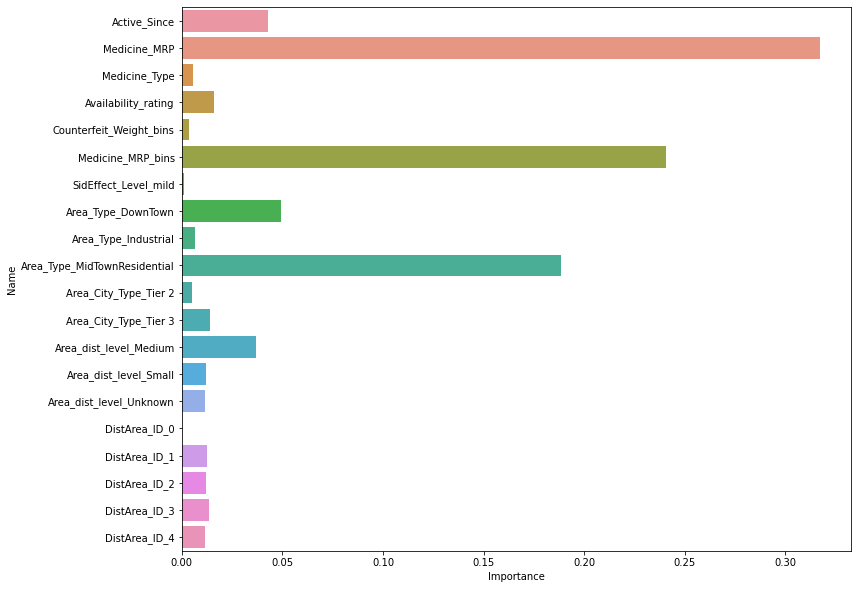

In [37]:
feat_imp=pd.DataFrame(list(zip(train_d.columns, rfr_best.feature_importances_)), columns=['Name', 'Importance'])

plt.figure(figsize= (12,10))
sns.barplot(y=feat_imp['Name'], x=feat_imp['Importance'])

feat_imp.sort_values('Importance')

In [37]:
xgb_rs_best.fit(x_train, y_train) 
prd_val=xgb_rs_best.predict(x_test)
prd_val = trgt_scale.inverse_transform(np.array(prd_val).reshape(-1,1))

In [41]:
prd_val.shape

(1705, 1)

In [38]:
sales_pred = pd.DataFrame(prd_val)

In [42]:
sales_pred.head()

,0
0,2143.917480
1,3881.666260
2,1492.792725
3,304.833771
4,462.733795


In [50]:
sales_pred.shape

(1705, 1)

In [43]:
df = pd.read_csv('Project3.csv')

In [44]:
df

,Medicine_ID,Counterfeit_Sales
0,HLZ81,0
1,ECE94,0
2,SAD14,0
3,EQV63,0
4,AIR10,0
...,...,...
1700,KXW10,0
1701,CKE54,0
1702,HAY13,0
1703,ZEE32,0


In [45]:
df["Counterfeit_Sales"] = sales_pred

In [46]:
df

,Medicine_ID,Counterfeit_Sales
0,HLZ81,2143.917480
1,ECE94,3881.666260
2,SAD14,1492.792725
3,EQV63,304.833771
4,AIR10,462.733795
...,...,...
1700,KXW10,3258.753906
1701,CKE54,910.917053
1702,HAY13,2993.285400
1703,ZEE32,3348.094482


In [48]:
df.to_csv("Project3.csv", index=False)

In [49]:
df

,Medicine_ID,Counterfeit_Sales
0,HLZ81,2143.917480
1,ECE94,3881.666260
2,SAD14,1492.792725
3,EQV63,304.833771
4,AIR10,462.733795
...,...,...
1700,KXW10,3258.753906
1701,CKE54,910.917053
1702,HAY13,2993.285400
1703,ZEE32,3348.094482
